# MMM calibratino with geo-level lift tests

## Introduction

This notebook demonstrates how to calibrate a multidimensional MMM using lift test results from a geo-level experiment. While [national-level lift tests](mmm_lift_test.ipynb) use interrupted time series analysis, geo-level experiments use synthetic control methods because we have both treated and control geographic units.

### When to Use Geo-Level Lift Tests

Geo-level lift tests are appropriate when you can:

- **Target specific geographic regions**: Digital campaigns with location targeting, regional TV markets, or store-level interventions
- **Hold out control regions**: Some geos receive the treatment while others serve as controls
- **Measure regional outcomes**: Sales, conversions, or other metrics at the geographic level

Common use cases include:
- Testing new digital ad creative in select markets
- Evaluating regional TV campaigns
- Assessing store-level promotions or merchandising changes
- Validating geo-targeted social media campaigns

### Workflow Overview

1. **Run a geo-level experiment**: Apply treatment to some geos, keep others as controls
2. **Analyze with synthetic control**: Use CausalPy to estimate the treatment effect (see [CausalPy multi-cell geolift docs](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html))
3. **Extract lift measurements**: Get `delta_y` (lift) and `sigma` (uncertainty) for each treated geo
4. **Calibrate MMM**: Add lift test measurements to constrain MMM parameters
5. **Improved estimates**: Narrower posteriors, better separated channels, geo-specific saturation curves

**Note**: This notebook focuses on steps 3-5. For the experiment analysis (steps 1-2), see the [CausalPy documentation](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html).

## Goal

We'll demonstrate:
1. **The problem**: Without lift tests, MMM struggles to separate correlated channels and identify geo-specific effects
2. **The solution**: Geo-level lift test measurements constrain parameters
3. **Parameter recovery**: Calibrated models recover true parameters more accurately

Let's get started!

## Important Notes for Running This Notebook

**This notebook must be run sequentially from top to bottom**. Key points:

1. **After Cells 11 & 20 (Model Fitting)**: We added `extend_idata=True` to `sample_posterior_predictive()`. If you get `KeyError: 'y_original_scale'` in later cells, you need to re-run the fitting cells (11 and 20) after this fix.

2. **Baseline vs Intercept**: The model learns an `intercept` parameter through scaled data, which isn't directly comparable to our true `baseline` used in data generation. Focus on lambda and beta parameters for validation.

## Prepare Notebook

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.dpi"] = 100
az.style.use("arviz-darkgrid")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed = 42
rng = np.random.default_rng(seed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate Synthetic Data with Known Parameters

We'll create data for 12 geos with 3 media channels. The key features:

- **Multiple geos**: 12 geographic markets with varying baseline sales
- **Correlated channels**: Two channels are highly correlated, making them hard to separate
- **Known treatment effects**: We'll simulate a lift test experiment on channel 1 in 6 geos
- **Geo-specific parameters**: Different saturation curves and effectiveness across geos

This allows us to validate that calibration improves parameter recovery.

In [2]:
# Define geos and channels
n_geos = 12
geos = [f"geo_{i:02d}" for i in range(n_geos)]
channels = ["channel_1", "channel_2", "channel_3"]
n_channels = len(channels)

# Time series parameters
n_weeks = 156  # 3 years of weekly data
dates = pd.date_range(start="2021-01-04", periods=n_weeks, freq="W-MON")

print(f"Creating data for {n_geos} geos, {n_channels} channels, {n_weeks} weeks")
print(f"Geos: {geos}")
print(f"Channels: {channels}")
print(f"Date range: {dates[0]} to {dates[-1]}")

Creating data for 12 geos, 3 channels, 156 weeks
Geos: ['geo_00', 'geo_01', 'geo_02', 'geo_03', 'geo_04', 'geo_05', 'geo_06', 'geo_07', 'geo_08', 'geo_09', 'geo_10', 'geo_11']
Channels: ['channel_1', 'channel_2', 'channel_3']
Date range: 2021-01-04 00:00:00 to 2023-12-25 00:00:00


### Generate Media Spend Data

We'll create realistic media spend patterns:
- Channel 1 and Channel 2 are highly correlated (challenging for MMM)
- Channel 3 is independent
- Each geo has different spending patterns

In [3]:
# Generate base spend patterns
# Channel 1: Base pattern with trend and seasonality
t = np.arange(n_weeks)
base_spend_1 = 5000 + 100 * np.sin(2 * np.pi * t / 52) + 50 * t / n_weeks

# Channel 2: Highly correlated with channel 1 + small noise
base_spend_2 = base_spend_1 * 0.85 + rng.normal(0, 200, n_weeks)

# Channel 3: Independent pattern
base_spend_3 = 3000 + 150 * np.cos(2 * np.pi * t / 52) + rng.normal(0, 500, n_weeks)

# Create DataFrame with geo-specific variations
data_list = []

for geo_idx, geo in enumerate(geos):
    # Geo-specific multipliers (some geos spend more than others)
    geo_multiplier = 0.7 + (geo_idx / n_geos) * 0.6  # Range from 0.7 to 1.3

    # Add geo-specific noise
    noise_1 = rng.normal(0, 300, n_weeks)
    noise_2 = rng.normal(0, 300, n_weeks)
    noise_3 = rng.normal(0, 400, n_weeks)

    spend_1 = np.maximum(0, (base_spend_1 + noise_1) * geo_multiplier)
    spend_2 = np.maximum(0, (base_spend_2 + noise_2) * geo_multiplier)
    spend_3 = np.maximum(0, (base_spend_3 + noise_3) * geo_multiplier * 1.1)

    for week_idx, date in enumerate(dates):
        data_list.append(
            {
                "date": date,
                "geo": geo,
                "channel_1": spend_1[week_idx],
                "channel_2": spend_2[week_idx],
                "channel_3": spend_3[week_idx],
            }
        )

df = pd.DataFrame(data_list)

# Display spend summary
print("\nSpend summary by channel:")
for channel in channels:
    print(
        f"{channel}: Mean=${df[channel].mean():.0f}, "
        f"Std=${df[channel].std():.0f}, "
        f"Min=${df[channel].min():.0f}, "
        f"Max=${df[channel].max():.0f}"
    )

# Check correlation between channels
print("\nChannel correlation matrix:")
print(df[["channel_1", "channel_2", "channel_3"]].corr().round(3))


Spend summary by channel:
channel_1: Mean=$4898, Std=$918, Min=$2992, Max=$7180
channel_2: Mean=$4141, Std=$823, Min=$2288, Max=$6494
channel_3: Mean=$3241, Std=$916, Min=$660, Max=$6463

Channel correlation matrix:
           channel_1  channel_2  channel_3
channel_1      1.000      0.857      0.611
channel_2      0.857      1.000      0.581
channel_3      0.611      0.581      1.000


### Visualize Spend Patterns

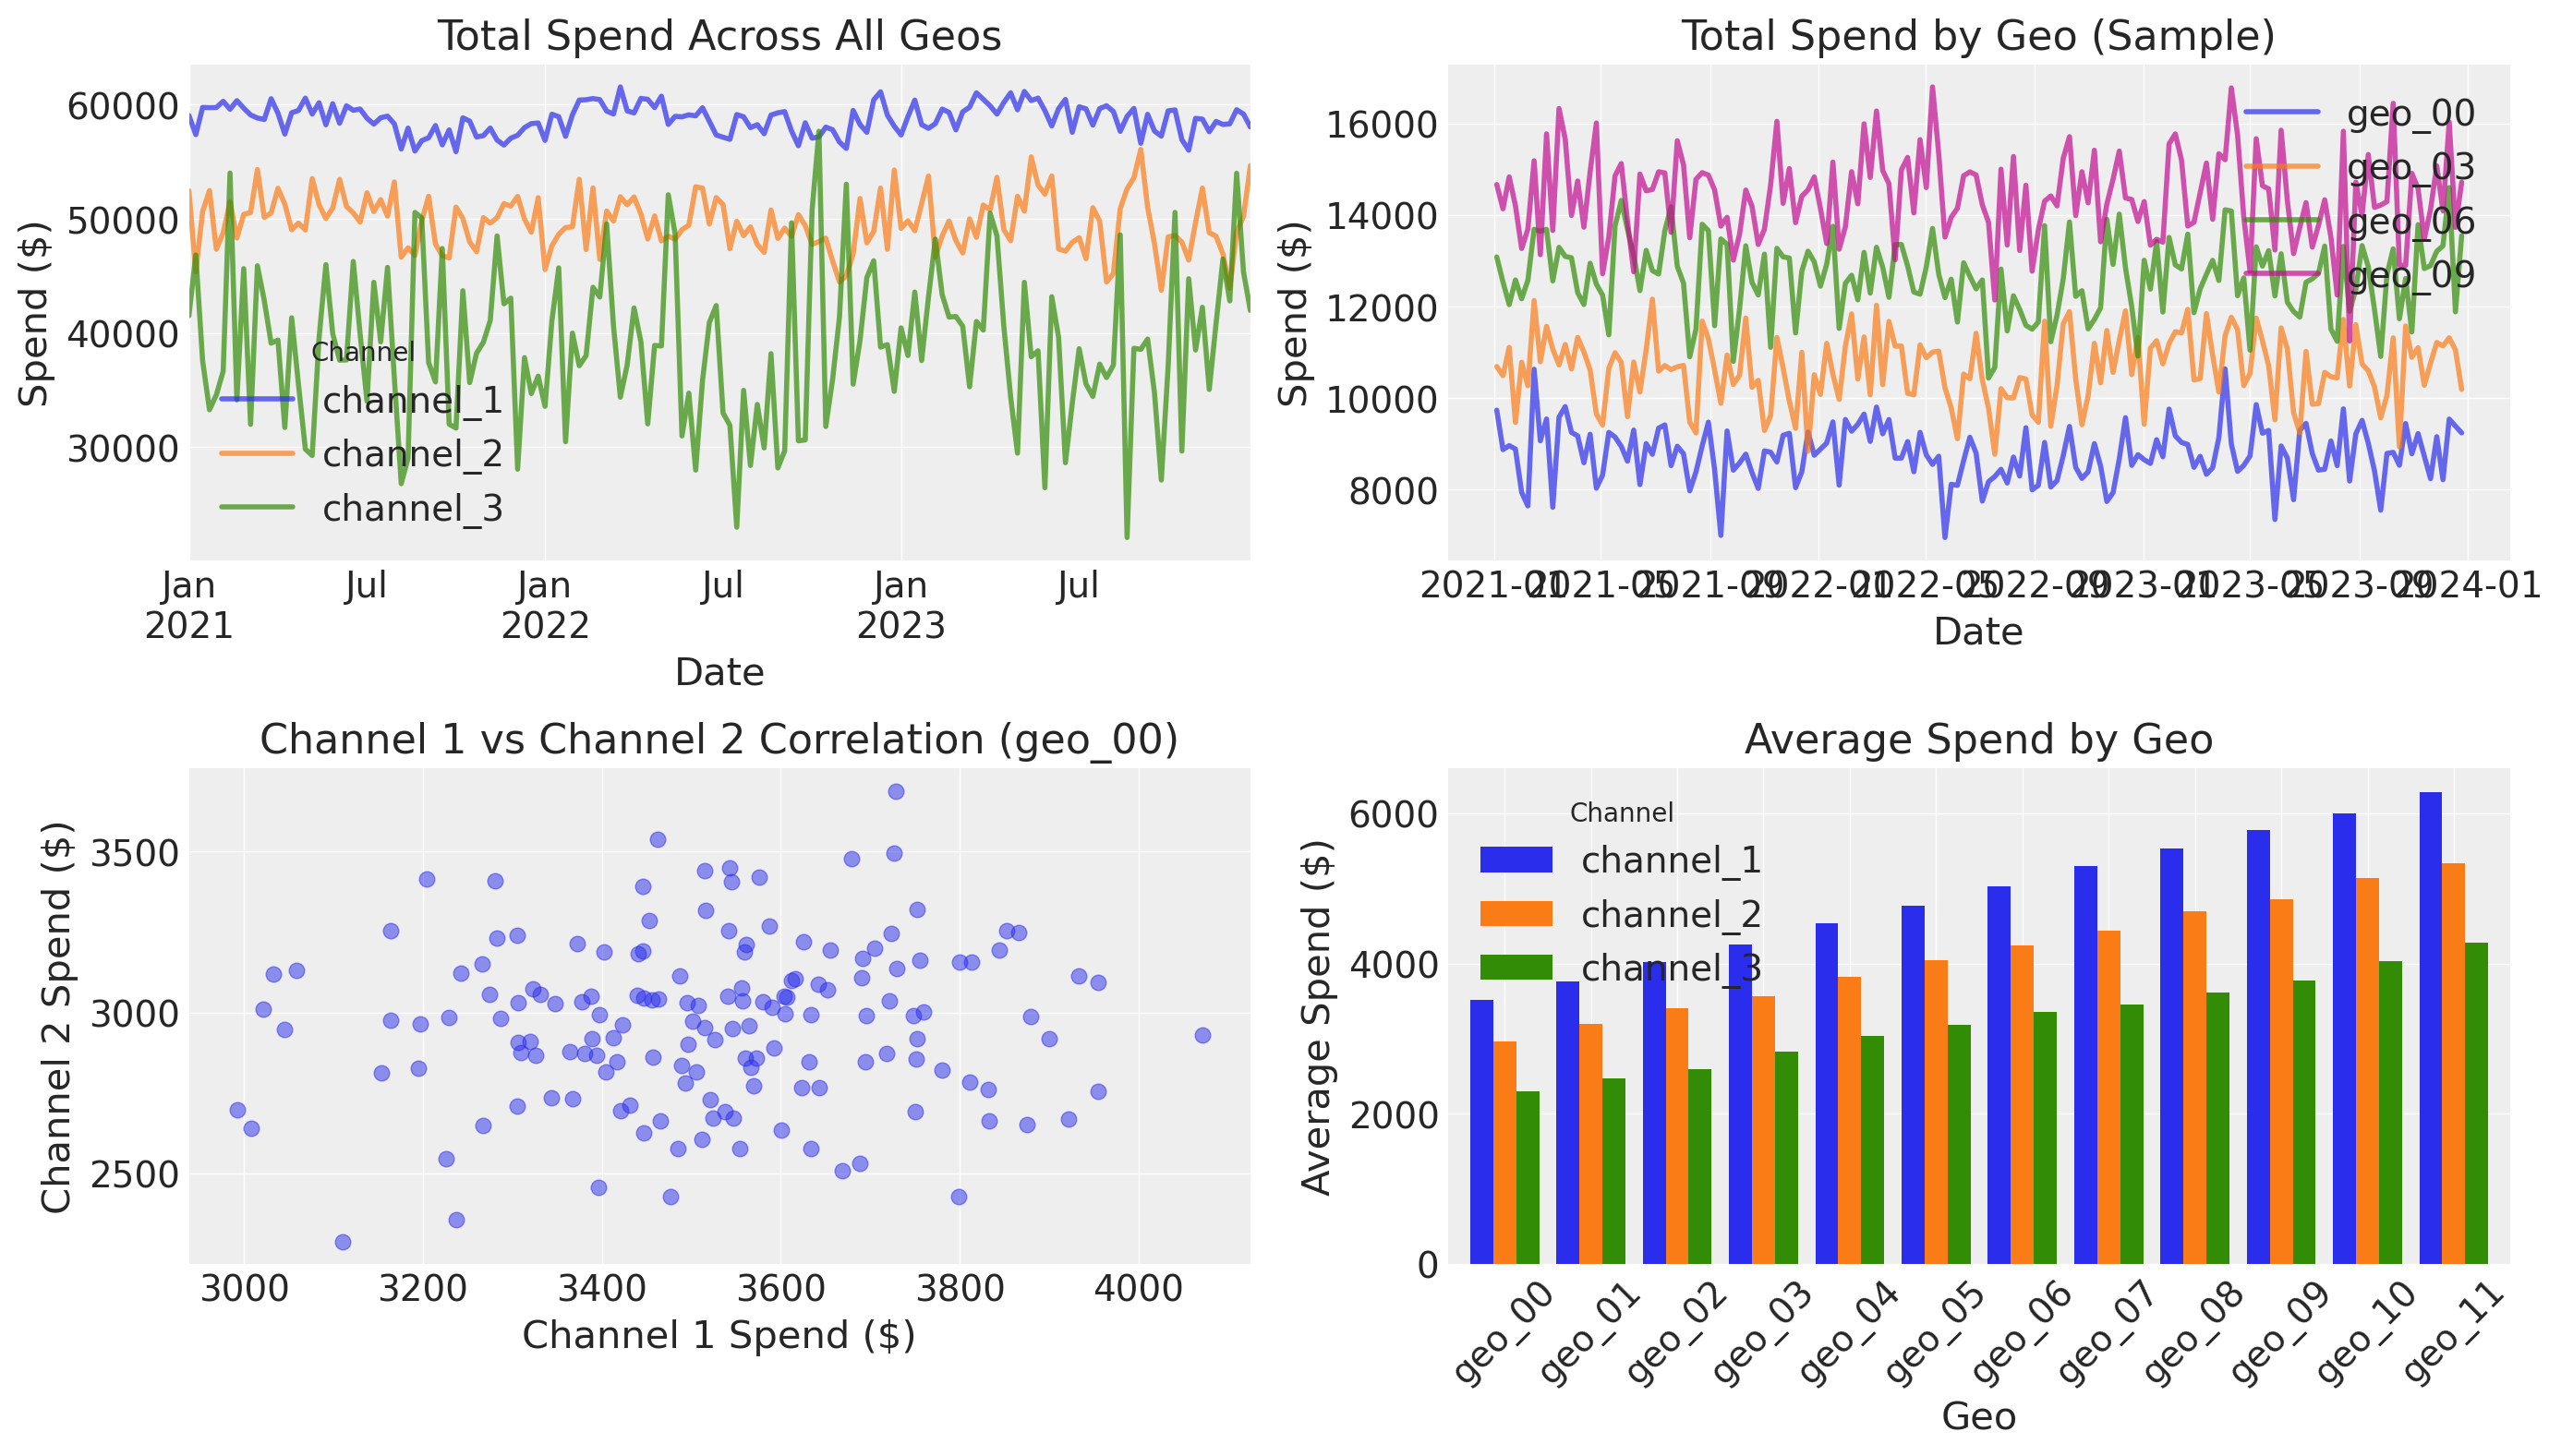

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Overall spend over time
ax = axes[0, 0]
df_agg = df.groupby("date")[["channel_1", "channel_2", "channel_3"]].sum()
df_agg.plot(ax=ax, alpha=0.7)
ax.set_title("Total Spend Across All Geos")
ax.set_xlabel("Date")
ax.set_ylabel("Spend ($)")
ax.legend(title="Channel")

# Plot 2: Spend by geo (showing 4 example geos)
ax = axes[0, 1]
example_geos = [geos[0], geos[3], geos[6], geos[9]]
for geo in example_geos:
    geo_data = df[df["geo"] == geo]
    total_spend = geo_data[["channel_1", "channel_2", "channel_3"]].sum(axis=1)
    ax.plot(geo_data["date"], total_spend, label=geo, alpha=0.7)
ax.set_title("Total Spend by Geo (Sample)")
ax.set_xlabel("Date")
ax.set_ylabel("Spend ($)")
ax.legend()

# Plot 3: Correlation scatter
ax = axes[1, 0]
sample_geo = df[df["geo"] == geos[0]]
ax.scatter(sample_geo["channel_1"], sample_geo["channel_2"], alpha=0.5)
ax.set_title(f"Channel 1 vs Channel 2 Correlation ({geos[0]})")
ax.set_xlabel("Channel 1 Spend ($)")
ax.set_ylabel("Channel 2 Spend ($)")

# Plot 4: Average spend by geo
ax = axes[1, 1]
geo_avg = df.groupby("geo")[["channel_1", "channel_2", "channel_3"]].mean()
geo_avg.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Average Spend by Geo")
ax.set_xlabel("Geo")
ax.set_ylabel("Average Spend ($)")
ax.legend(title="Channel")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Define True Parameters and Generate Target Variable

Now we'll define the true parameters for each geo and channel, then generate the target variable (sales/conversions).

**Key parameters**:
- **Baseline**: Organic sales/conversions (varies by geo)
- **Saturation lambda**: Controls how quickly each channel saturates (varies by geo and channel)
- **Saturation beta**: Maximum contribution of each channel (varies by geo and channel)
- **Adstock alpha**: Carryover effect (0-1, varies by channel)

We'll make channel 1 and channel 2 have similar effectiveness, making them hard to separate without lift tests.

In [5]:
# True parameters (these would be unknown in practice)
true_params = {}

# Baseline varies by geo (organic sales)
true_params["baseline"] = {
    geo: 3000 + idx * 200 + rng.normal(0, 300) for idx, geo in enumerate(geos)
}

# Saturation lambda (higher = saturates more slowly)
# Channel 1 and 2 have similar lambdas (hard to separate)
true_params["saturation_lam"] = {}
for geo in geos:
    true_params["saturation_lam"][geo] = {
        "channel_1": rng.uniform(0.0015, 0.0025),
        "channel_2": rng.uniform(0.0018, 0.0028),  # Similar to channel 1
        "channel_3": rng.uniform(0.0008, 0.0015),  # Different
    }

# Saturation beta (contribution coefficient)
# Channel 1 and 2 have similar betas
true_params["saturation_beta"] = {}
for geo in geos:
    true_params["saturation_beta"][geo] = {
        "channel_1": rng.uniform(0.35, 0.45),
        "channel_2": rng.uniform(0.32, 0.42),  # Similar to channel 1
        "channel_3": rng.uniform(0.20, 0.30),  # Lower contribution
    }

# Adstock alpha (carryover effect, same across geos for simplicity)
true_params["adstock_alpha"] = {
    "channel_1": 0.7,
    "channel_2": 0.6,
    "channel_3": 0.5,
}

print("True parameters defined:")
print(
    f"  Baseline range: ${min(true_params['baseline'].values()):.0f} - ${max(true_params['baseline'].values()):.0f}"
)
print("  Saturation lambda ranges by channel:")
for ch in channels:
    lam_values = [true_params["saturation_lam"][g][ch] for g in geos]
    print(f"    {ch}: {min(lam_values):.4f} - {max(lam_values):.4f}")
print(f"  Adstock alpha: {true_params['adstock_alpha']}")

True parameters defined:
  Baseline range: $3177 - $5383
  Saturation lambda ranges by channel:
    channel_1: 0.0016 - 0.0025
    channel_2: 0.0019 - 0.0028
    channel_3: 0.0009 - 0.0015
  Adstock alpha: {'channel_1': 0.7, 'channel_2': 0.6, 'channel_3': 0.5}


In [6]:
# Saturation function (logistic)
def logistic_saturation(x, lam):
    return (1 - np.exp(-lam * x)) / (1 + np.exp(-lam * x))


# Adstock function (geometric)
def geometric_adstock(x, alpha):
    """Apply geometric adstock transformation."""
    adstocked = np.zeros_like(x)
    adstocked[0] = x[0]
    for t in range(1, len(x)):
        adstocked[t] = x[t] + alpha * adstocked[t - 1]
    return adstocked


# Generate target variable
df["y"] = 0.0

for geo in geos:
    geo_mask = df["geo"] == geo
    geo_data = df[geo_mask].copy()

    # Start with baseline
    y_geo = np.full(len(geo_data), true_params["baseline"][geo])

    # Add contribution from each channel
    for channel in channels:
        # Get spend for this channel
        x = geo_data[channel].values

        # Apply adstock
        alpha = true_params["adstock_alpha"][channel]
        x_adstocked = geometric_adstock(x, alpha)

        # Apply saturation
        lam = true_params["saturation_lam"][geo][channel]
        x_saturated = logistic_saturation(x_adstocked, lam)

        # Apply beta (contribution coefficient)
        beta = true_params["saturation_beta"][geo][channel]

        # Add contribution
        y_geo += beta * x_saturated * 10000  # Scale factor

    # Add noise
    y_geo += rng.normal(0, 500, len(geo_data))

    # Ensure non-negative
    y_geo = np.maximum(y_geo, 0)

    # Assign to dataframe
    df.loc[geo_mask, "y"] = y_geo

print("\nTarget variable (y) generated:")
print(f"  Mean: {df['y'].mean():.0f}")
print(f"  Std: {df['y'].std():.0f}")
print(f"  Min: {df['y'].min():.0f}")
print(f"  Max: {df['y'].max():.0f}")

# Show first few rows
df.head(15)


Target variable (y) generated:
  Mean: 13962
  Std: 1260
  Min: 10993
  Max: 17303


,date,geo,channel_1,channel_2,channel_3,y
0,2021-01-04,geo_00,3866.226250,3249.918999,2620.765669,11318.567019
1,2021-01-11,geo_00,3600.850490,2634.725728,2638.709264,12627.123138
2,2021-01-18,geo_00,3691.078332,3167.702635,2103.130371,12661.309856
3,2021-01-25,geo_00,3463.215519,3042.863737,2381.484959,12310.034230
4,2021-02-01,geo_00,3547.402679,2670.552517,1720.199713,11841.853857
5,2021-02-08,geo_00,3394.427324,2866.366633,1382.706260,11759.161875
6,2021-02-15,geo_00,3755.577366,3163.523620,3712.082433,12807.968072
7,2021-02-22,geo_00,3306.522504,2905.353081,2855.549805,11540.007032
8,2021-03-01,geo_00,3723.697314,3246.549841,2573.606888,12827.075082
9,2021-03-08,geo_00,3523.964430,2670.167802,1419.502446,12197.527934


### Visualize Generated Data

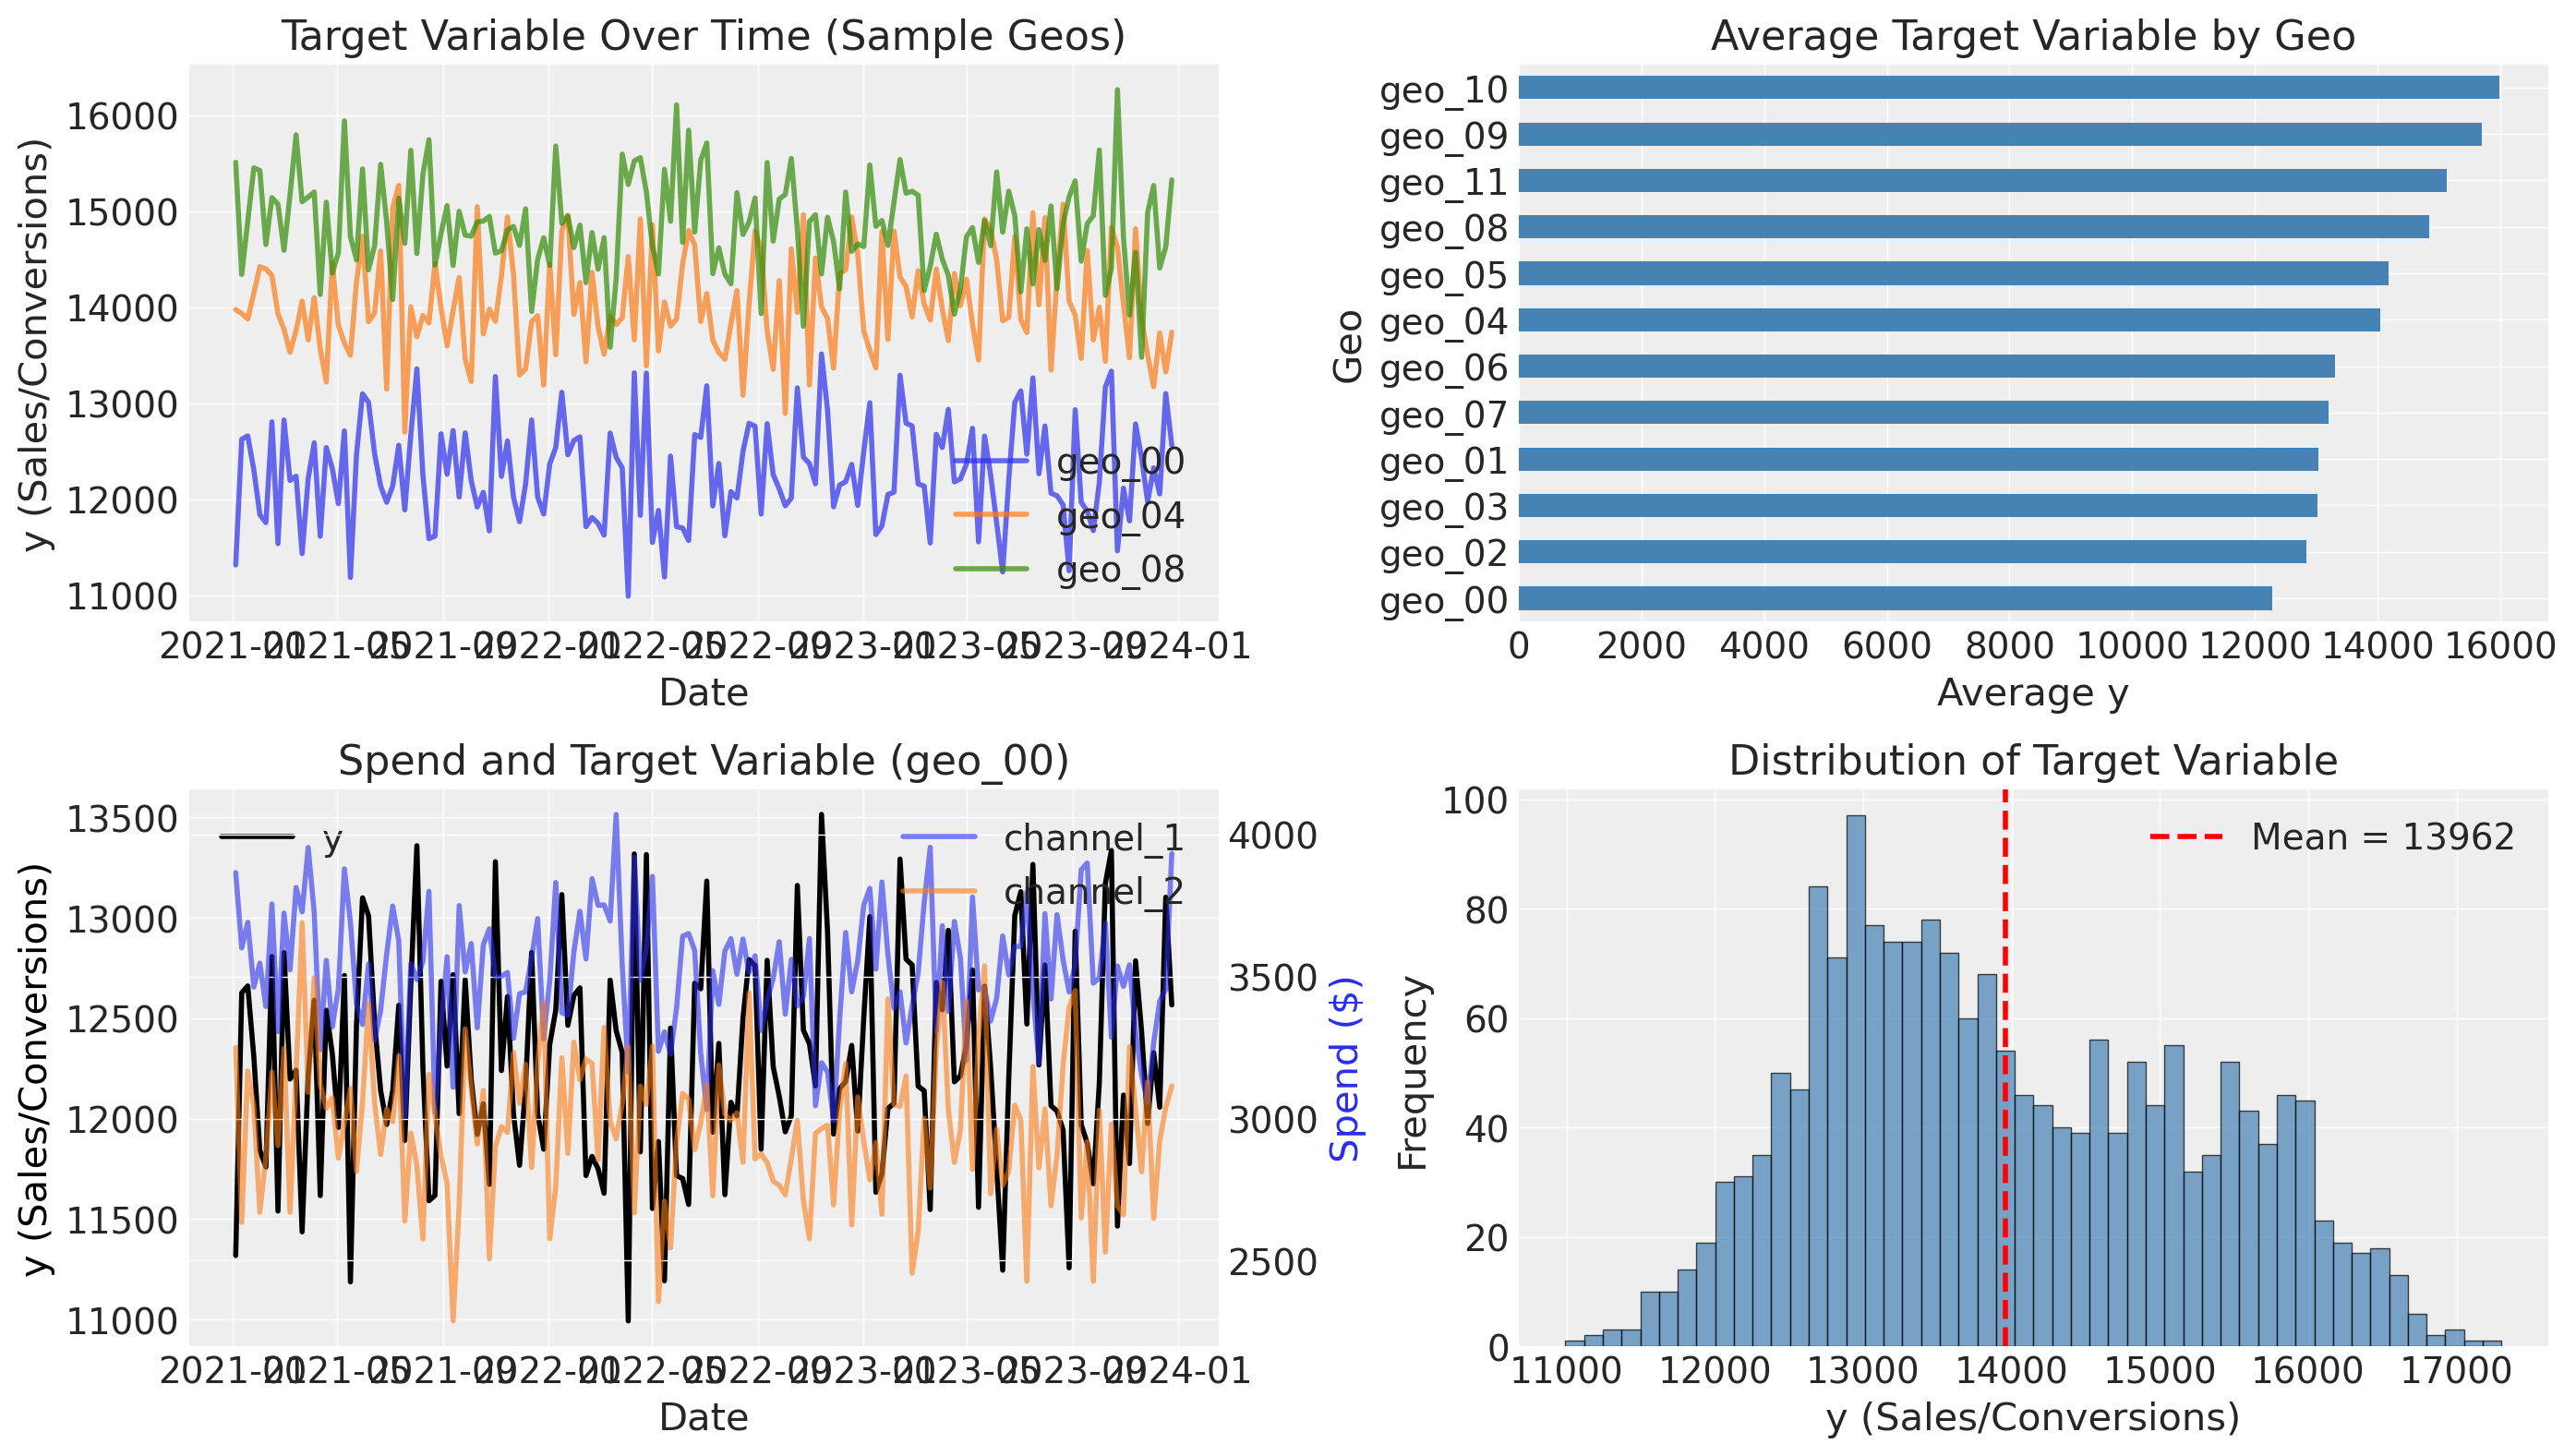

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Time series of y for sample geos
ax = axes[0, 0]
sample_geos = [geos[0], geos[4], geos[8]]
for geo in sample_geos:
    geo_data = df[df["geo"] == geo]
    ax.plot(geo_data["date"], geo_data["y"], label=geo, alpha=0.7)
ax.set_title("Target Variable Over Time (Sample Geos)")
ax.set_xlabel("Date")
ax.set_ylabel("y (Sales/Conversions)")
ax.legend()

# Plot 2: Average y by geo
ax = axes[0, 1]
geo_avg_y = df.groupby("geo")["y"].mean().sort_values()
geo_avg_y.plot(kind="barh", ax=ax, color="steelblue")
ax.set_title("Average Target Variable by Geo")
ax.set_xlabel("Average y")
ax.set_ylabel("Geo")

# Plot 3: Spend vs y for one geo
ax = axes[1, 0]
geo_example = df[df["geo"] == geos[0]]
ax2 = ax.twinx()
ax.plot(geo_example["date"], geo_example["y"], color="black", label="y", linewidth=2)
ax2.plot(
    geo_example["date"],
    geo_example["channel_1"],
    color="C0",
    alpha=0.6,
    label="channel_1",
)
ax2.plot(
    geo_example["date"],
    geo_example["channel_2"],
    color="C1",
    alpha=0.6,
    label="channel_2",
)
ax.set_title(f"Spend and Target Variable ({geos[0]})")
ax.set_xlabel("Date")
ax.set_ylabel("y (Sales/Conversions)", color="black")
ax2.set_ylabel("Spend ($)", color="C0")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

# Plot 4: Distribution of y across all observations
ax = axes[1, 1]
ax.hist(df["y"], bins=50, edgecolor="black", alpha=0.7, color="steelblue")
ax.set_title("Distribution of Target Variable")
ax.set_xlabel("y (Sales/Conversions)")
ax.set_ylabel("Frequency")
ax.axvline(
    df["y"].mean(), color="red", linestyle="--", label=f"Mean = {df['y'].mean():.0f}"
)
ax.legend()

plt.tight_layout()
plt.show()

## Fit MMM Without Calibration

First, let's fit a standard multidimensional MMM without any lift test calibration. This will establish our baseline and demonstrate the parameter identification problem.

### Prepare Data for MMM

In [8]:
# Prepare X (features) and y (target)
X = df[["date", "geo", "channel_1", "channel_2", "channel_3"]].copy()
y = df["y"]

print("Data prepared for MMM:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Number of geos: {X['geo'].nunique()}")
print(f"  Number of time periods: {X['date'].nunique()}")
print(f"  Channels: {[c for c in X.columns if c not in ['date', 'geo']]}")

Data prepared for MMM:
  X shape: (1872, 5)
  y shape: (1872,)
  Number of geos: 12
  Number of time periods: 156
  Channels: ['channel_1', 'channel_2', 'channel_3']


### Define Model Priors

We'll use weakly informative priors. Without lift test calibration, the model will struggle to separate the highly correlated channels.

In [9]:
# Define priors
channel_columns = ["channel_1", "channel_2", "channel_3"]

adstock_priors = {
    "alpha": Prior("Beta", alpha=2, beta=2, dims="channel"),
}

saturation_priors = {
    # Prior for lam: LogNormal(mu=-6, sigma=1) has median exp(-6) ≈ 0.0025
    # which matches our true values around 0.001-0.003
    # NOTE: Use Prior("LogNormal", ...) for log-scale parameterization.
    # LogNormalPrior takes positive-scale mean/std, which is different!
    "lam": Prior("LogNormal", mu=-6, sigma=1, dims=("geo", "channel")),
    "beta": Prior("HalfNormal", sigma=1, dims=("geo", "channel")),
}

print("Model priors defined:")
print(f"  Adstock: {adstock_priors}")
print(f"  Saturation: {saturation_priors}")

Model priors defined:
  Adstock: {'alpha': Prior("Beta", alpha=2, beta=2, dims="channel")}
  Saturation: {'lam': Prior("LogNormal", mu=-6, sigma=1, dims=("geo", "channel")), 'beta': Prior("HalfNormal", sigma=1, dims=("geo", "channel"))}


### Build and Fit Model

In [10]:
# Initialize MMM
mmm_uncalibrated = MMM(
    date_column="date",
    channel_columns=channel_columns,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

# Build model
mmm_uncalibrated.build_model(X, y)

print("Model built successfully")
print(f"Model coordinates: {list(mmm_uncalibrated.model.coords.keys())}")

Model built successfully
Model coordinates: ['date', 'geo', 'channel']


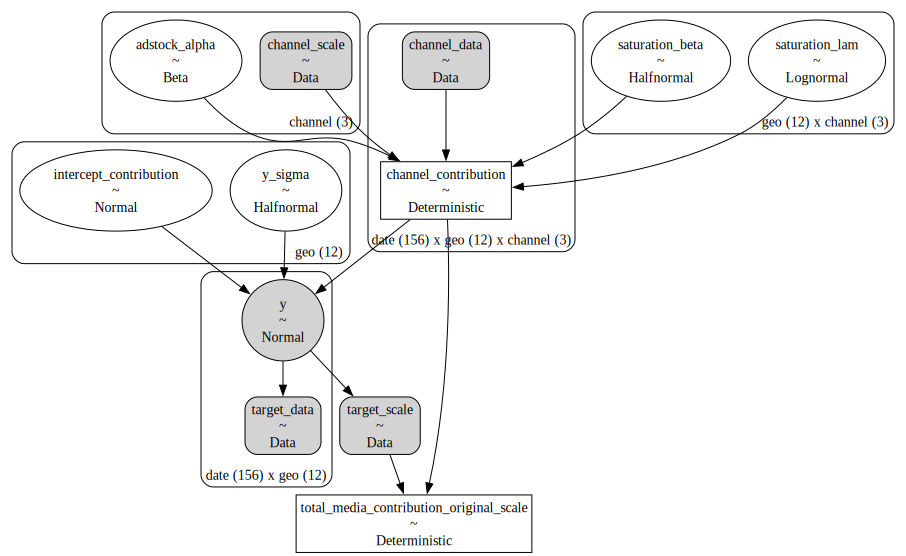

In [11]:
mmm_uncalibrated.model.to_graphviz()

In [12]:
# Fit model (using fast sampling for demo purposes)
# In practice, you'd want more draws and chains
fit_kwargs = {
    "nuts_sampler": "nutpie",
    # "draws": 2000,
    # "tune": 1000,
    # "chains": 4,
    "random_seed": rng,
    # "target_accept": 0.9,
}

idata_uncalibrated = mmm_uncalibrated.fit(X, y, **fit_kwargs)

print("\nModel fitted successfully")
print(f"Posterior shape: {idata_uncalibrated.posterior.dims}")

# Generate posterior predictive samples
mmm_uncalibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)
print("Posterior predictive samples generated")
print(
    f"  Available variables: {list(mmm_uncalibrated.idata.posterior_predictive.data_vars)}"
)

Error updating progress display: <ContextVar name='parent_header' at 0x1061db970>


Sampling: [y]



Model fitted successfully
Posterior shape: FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 1000, 'geo': 12, 'adstock_alpha_logodds___dim_0': 3, 'saturation_lam_log___dim_0': 12, 'saturation_lam_log___dim_1': 3, 'saturation_beta_log___dim_0': 12, 'saturation_beta_log___dim_1': 3, 'y_sigma_log___dim_0': 12, 'channel': 3, 'date': 156})


Posterior predictive samples generated
  Available variables: ['y']


### Examine Parameter Estimates Without Calibration

Let's look at the parameter estimates and see how well they recover the true values.

In [13]:
# Extract posterior means for key parameters
posterior_uncal = idata_uncalibrated.posterior

# Saturation lambda
lam_uncal = posterior_uncal["saturation_lam"].mean(dim=["chain", "draw"])

# Saturation beta
beta_uncal = posterior_uncal["saturation_beta"].mean(dim=["chain", "draw"])

# Adstock alpha
alpha_uncal = posterior_uncal["adstock_alpha"].mean(dim=["chain", "draw"])

print("Uncalibrated model - Posterior means:")
print("\nAdstock alpha:")
for idx, ch in enumerate(channels):
    print(
        f"  {ch}: {alpha_uncal[idx].values:.3f} (true: {true_params['adstock_alpha'][ch]:.3f})"
    )

print("\nSaturation lambda (showing first 3 geos):")
for geo_idx in range(3):
    geo = geos[geo_idx]
    print(f"  {geo}:")
    for ch_idx, ch in enumerate(channels):
        est = lam_uncal[geo_idx, ch_idx].values
        true = true_params["saturation_lam"][geo][ch]
        print(f"    {ch}: {est:.4f} (true: {true:.4f})")

Uncalibrated model - Posterior means:

Adstock alpha:
  channel_1: 0.490 (true: 0.700)
  channel_2: 0.496 (true: 0.600)
  channel_3: 0.498 (true: 0.500)

Saturation lambda (showing first 3 geos):
  geo_00:
    channel_1: 0.0040 (true: 0.0016)
    channel_2: 0.0043 (true: 0.0019)
    channel_3: 0.0046 (true: 0.0014)
  geo_01:
    channel_1: 0.0039 (true: 0.0020)
    channel_2: 0.0039 (true: 0.0020)
    channel_3: 0.0040 (true: 0.0010)
  geo_02:
    channel_1: 0.0038 (true: 0.0022)
    channel_2: 0.0037 (true: 0.0019)
    channel_3: 0.0040 (true: 0.0009)


### Visualize Parameter Uncertainty

Plot the posterior distributions for selected parameters to see the uncertainty.

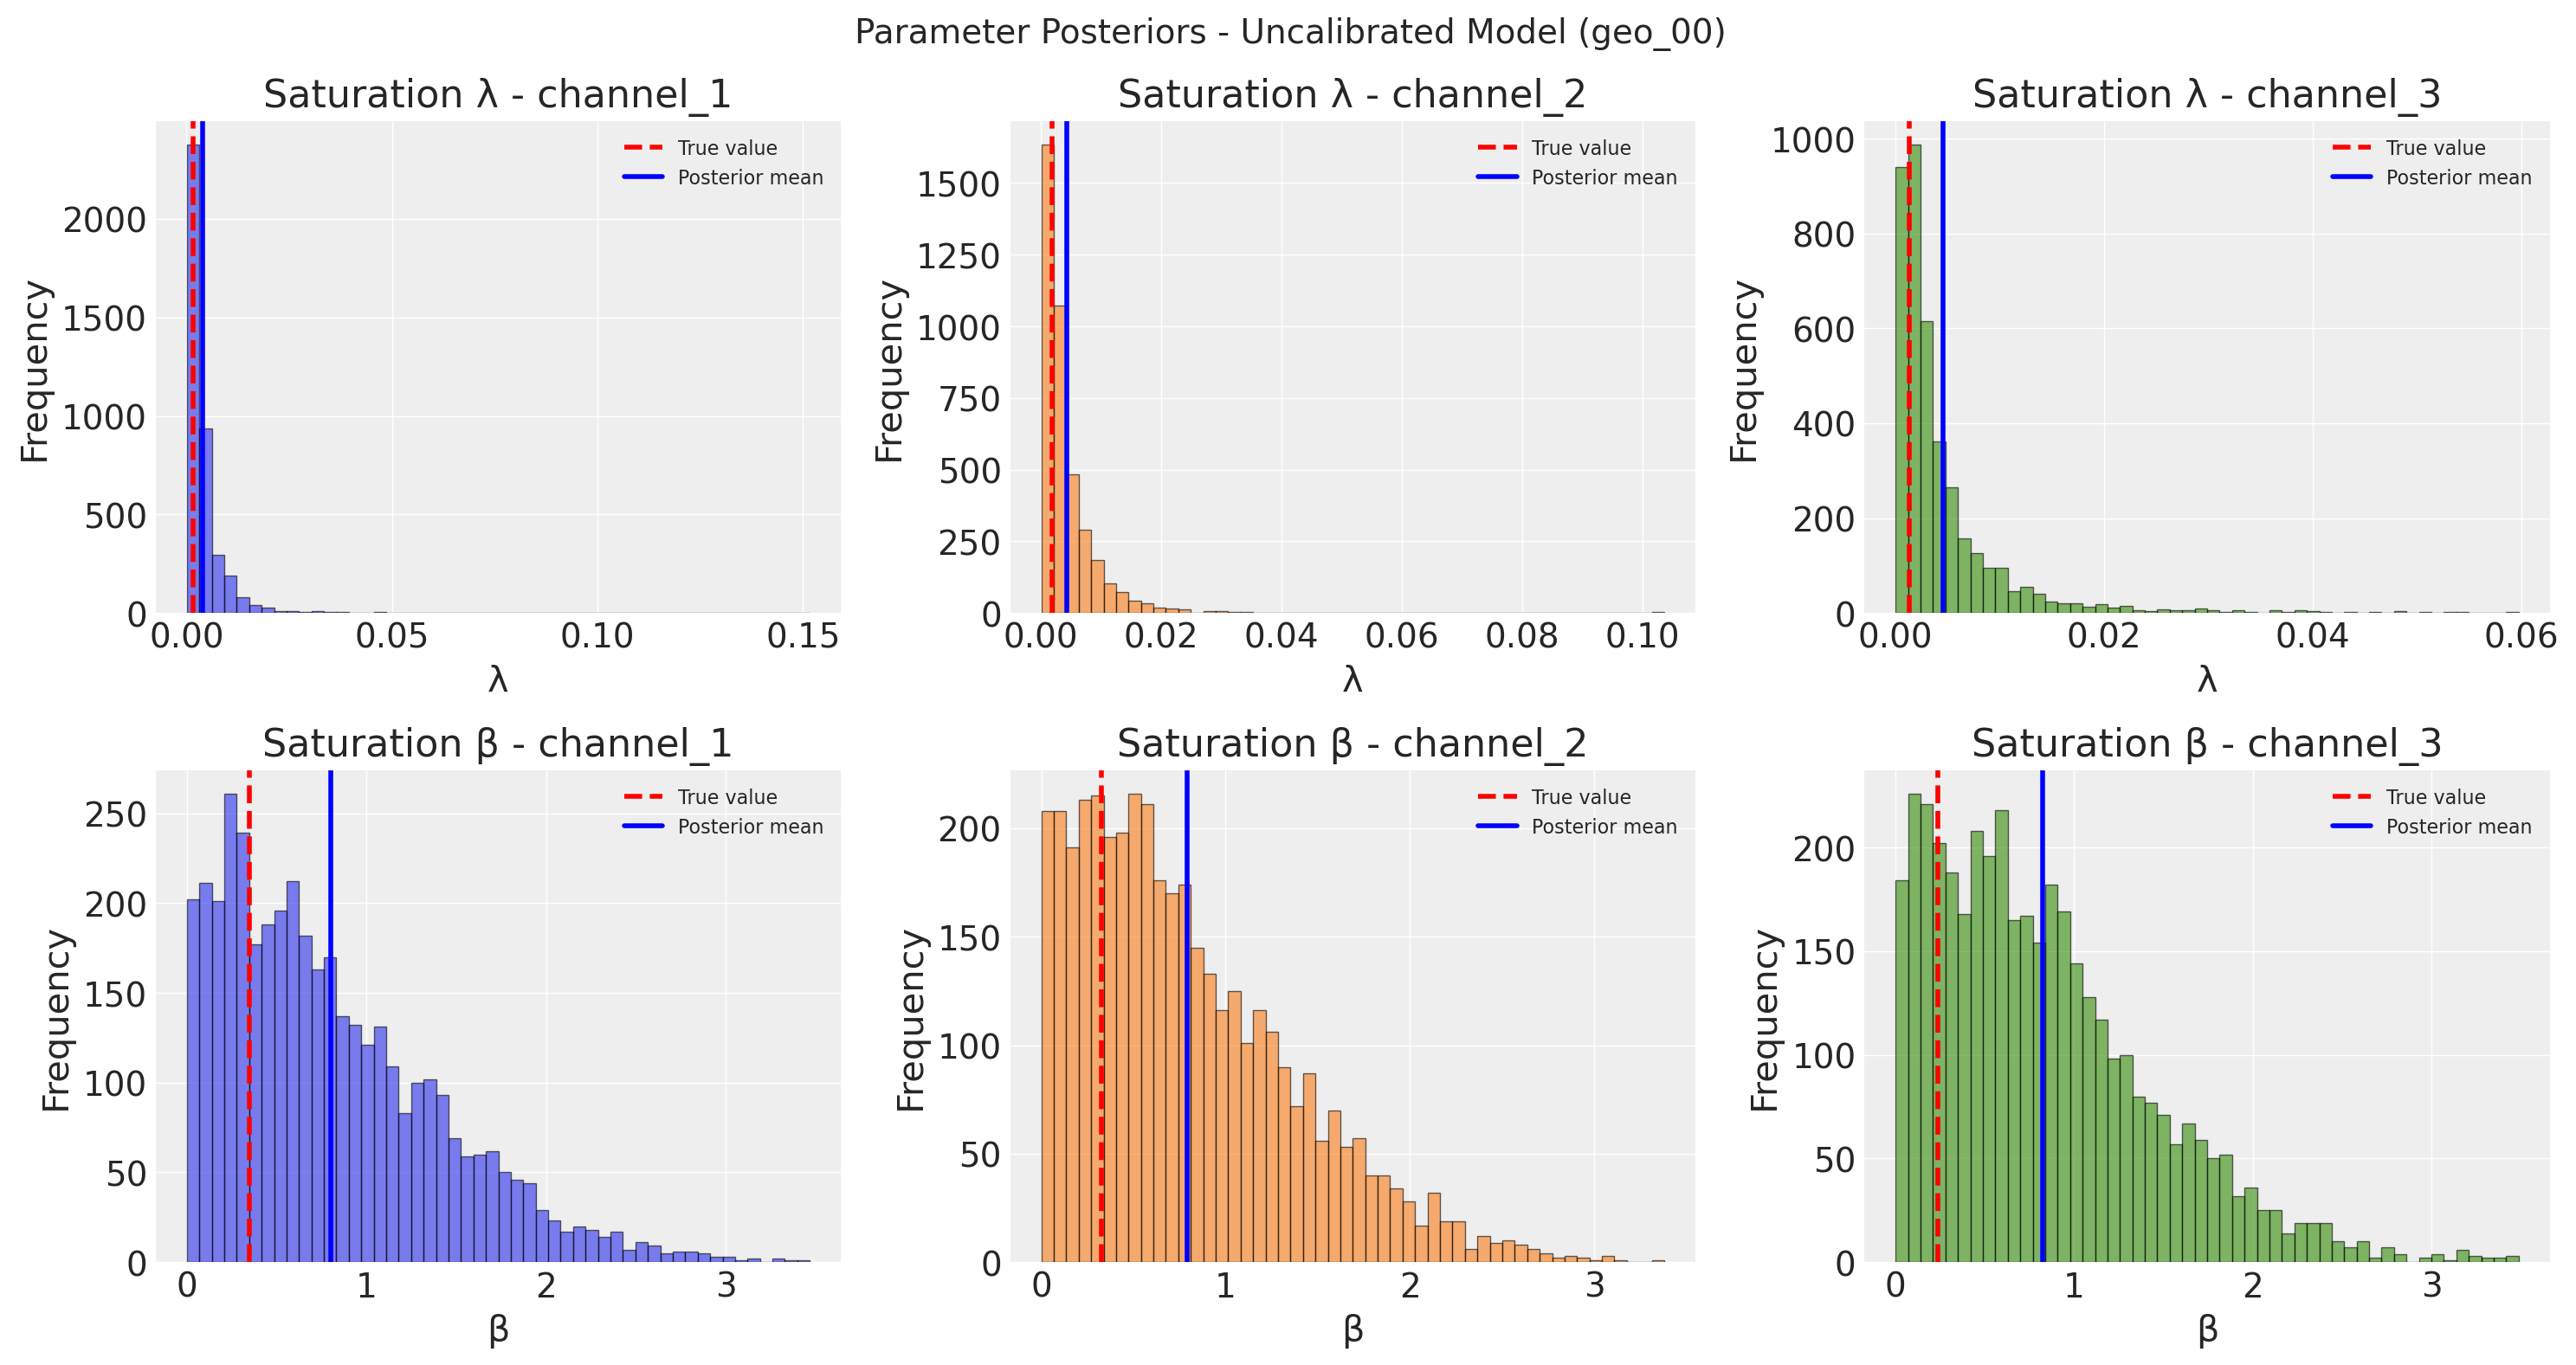


Note: Wide posteriors and poor recovery of true values indicate
      parameter identification issues (especially for correlated channels 1 & 2)


In [14]:
# Focus on one geo for visualization
focus_geo = geos[0]
focus_geo_idx = geos.index(focus_geo)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f"Parameter Posteriors - Uncalibrated Model ({focus_geo})", fontsize=14)

# Plot saturation lambda for each channel
for ch_idx, ch in enumerate(channels):
    ax = axes[0, ch_idx]

    # Get posterior samples
    samples = posterior_uncal["saturation_lam"][
        :, :, focus_geo_idx, ch_idx
    ].values.flatten()

    # Plot histogram
    ax.hist(samples, bins=50, alpha=0.6, color=f"C{ch_idx}", edgecolor="black")

    # Add true value line
    true_val = true_params["saturation_lam"][focus_geo][ch]
    ax.axvline(true_val, color="red", linestyle="--", linewidth=2, label="True value")

    # Add mean line
    ax.axvline(
        samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean"
    )

    ax.set_title(f"Saturation λ - {ch}")
    ax.set_xlabel("λ")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

# Plot saturation beta for each channel
for ch_idx, ch in enumerate(channels):
    ax = axes[1, ch_idx]

    # Get posterior samples
    samples = posterior_uncal["saturation_beta"][
        :, :, focus_geo_idx, ch_idx
    ].values.flatten()

    # Plot histogram
    ax.hist(samples, bins=50, alpha=0.6, color=f"C{ch_idx}", edgecolor="black")

    # Add true value line
    true_val = true_params["saturation_beta"][focus_geo][ch]
    ax.axvline(true_val, color="red", linestyle="--", linewidth=2, label="True value")

    # Add mean line
    ax.axvline(
        samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean"
    )

    ax.set_title(f"Saturation β - {ch}")
    ax.set_xlabel("β")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\nNote: Wide posteriors and poor recovery of true values indicate")
print(
    "      parameter identification issues (especially for correlated channels 1 & 2)"
)

## Simulate Geo-Level Lift Test

Now let's simulate a geo-level lift test experiment. In practice, you would:

1. **Conduct the experiment**: Apply treatment (increased spend) to some geos, keep others as controls
2. **Analyze with synthetic control**: Use [CausalPy's multi-cell geolift analysis](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html)
3. **Extract results**: Get `delta_y` (lift estimate) and `sigma` (uncertainty) for each treated geo

For this demo, we'll simulate the results of such an experiment on **channel 1** in **6 treated geos**, with the remaining 6 geos serving as controls.

### Define Lift Test Setup

In [15]:
# Select treated geos (6 out of 12)
treated_geos = [geos[i] for i in [0, 2, 4, 6, 8, 10]]  # Even-indexed geos
control_geos = [geos[i] for i in [1, 3, 5, 7, 9, 11]]  # Odd-indexed geos

# Test parameters
test_channel = "channel_1"
test_start_week = 104  # Start test at week 104 (2 years into data)
test_duration_weeks = 8  # 8-week test
delta_x = 2000  # Incremental spend increase during test ($ per week)

print("Lift Test Setup:")
print(f"  Test channel: {test_channel}")
print(f"  Treated geos ({len(treated_geos)}): {treated_geos}")
print(f"  Control geos ({len(control_geos)}): {control_geos}")
print(
    f"  Test period: Week {test_start_week} to {test_start_week + test_duration_weeks}"
)
print(f"  Incremental spend per week: ${delta_x}")

Lift Test Setup:
  Test channel: channel_1
  Treated geos (6): ['geo_00', 'geo_02', 'geo_04', 'geo_06', 'geo_08', 'geo_10']
  Control geos (6): ['geo_01', 'geo_03', 'geo_05', 'geo_07', 'geo_09', 'geo_11']
  Test period: Week 104 to 112
  Incremental spend per week: $2000


### Calculate True Lift Using Known Parameters

Since we know the true parameters, we can calculate what the true lift should be for each treated geo.

**Important**: The `add_lift_test_measurements()` method calibrates the **saturation curve directly**, not the full adstock+saturation pipeline. Therefore, the `x` and `delta_x` values in the lift test DataFrame should represent the **input to the saturation function** (i.e., adstocked spend), not raw spend.

For steady-state geometric adstock: `x_adstocked = x_raw / (1 - alpha)`

In [16]:
# Calculate true lift for each treated geo
lift_test_results = []

# Determine test period dates
test_start_date = dates[test_start_week]
test_end_date = dates[test_start_week + test_duration_weeks - 1]

print(f"Test period: {test_start_date} to {test_end_date}")

for geo in treated_geos:
    # Get test period data for this geo
    geo_mask = (
        (df["geo"] == geo)
        & (df["date"] >= test_start_date)
        & (df["date"] <= test_end_date)
    )

    # Get average baseline spend during test period
    geo_test_data = df[geo_mask]
    x_baseline_raw = geo_test_data[test_channel].mean()

    # Get true parameters for this geo
    alpha = true_params["adstock_alpha"][test_channel]
    lam = true_params["saturation_lam"][geo][test_channel]
    beta = true_params["saturation_beta"][geo][test_channel]

    # IMPORTANT: The lift test calibration works on the SATURATION curve directly,
    # not the full adstock+saturation pipeline. Therefore, we need to provide x
    # and delta_x in terms of the INPUT to the saturation function (i.e., adstocked values).
    #
    # For steady-state adstock: x_adstocked = x_raw / (1 - alpha)
    x_base_adstocked = x_baseline_raw / (1 - alpha)
    delta_x_adstocked = delta_x / (1 - alpha)  # Adstocked incremental spend
    x_treat_adstocked = x_base_adstocked + delta_x_adstocked

    print(
        f"  {geo}: raw_spend={x_baseline_raw:.1f}, adstocked_x={x_base_adstocked:.1f}"
    )

    # Calculate true lift using the saturation function
    # This is what the model's calibration will try to match
    y_base = beta * logistic_saturation(x_base_adstocked, lam) * 10000
    y_treat = beta * logistic_saturation(x_treat_adstocked, lam) * 10000

    # True lift
    true_lift = y_treat - y_base

    # Safety check: ensure positive lift for monotonicity
    if true_lift < 50:
        true_lift = 50 + rng.uniform(50, 200)  # Minimum reasonable lift

    # Simulate measurement uncertainty (sigma)
    # In practice, this comes from synthetic control confidence intervals
    sigma = abs(true_lift) * 0.15  # 15% uncertainty

    # Simulated measured lift (add noise, ensure positive)
    measured_lift = true_lift + rng.normal(0, sigma)
    # Ensure measured lift is positive (since delta_x is positive)
    measured_lift = max(measured_lift, true_lift * 0.1)  # At least 10% of true lift

    # Store ADSTOCKED x values in the lift test DataFrame
    # This is critical: the calibration applies saturation directly to these values
    lift_test_results.append(
        {
            "channel": test_channel,
            "geo": geo,
            "x": x_base_adstocked,  # Adstocked baseline spend
            "delta_x": delta_x_adstocked,  # Adstocked incremental spend
            "delta_y": measured_lift,
            "sigma": sigma,
            "true_lift": true_lift,
        }
    )

df_lift_test = pd.DataFrame(lift_test_results)

print("\nLift Test Results (with adstocked x values):")
print(df_lift_test.round(1))
print(
    f"\nAverage lift across treated geos: {df_lift_test['delta_y'].mean():.1f} ± {df_lift_test['sigma'].mean():.1f}"
)

Test period: 2023-01-02 00:00:00 to 2023-02-20 00:00:00
  geo_00: baseline=3574.9, n_periods=8
  geo_02: baseline=4055.9, n_periods=8
  geo_04: baseline=4696.4, n_periods=8
  geo_06: baseline=5033.1, n_periods=8
  geo_08: baseline=5352.2, n_periods=8
  geo_10: baseline=6226.1, n_periods=8

Lift Test Results:
     channel     geo       x  delta_x  delta_y  sigma  true_lift
0  channel_1  geo_00  3574.9     2000    112.8   20.5      136.4
1  channel_1  geo_02  4055.9     2000    225.4   37.3      248.4
2  channel_1  geo_04  4696.4     2000    152.4   28.8      192.3
3  channel_1  geo_06  5033.1     2000    186.5   28.0      186.6
4  channel_1  geo_08  5352.2     2000    209.9   33.4      222.8
5  channel_1  geo_10  6226.1     2000    157.1   18.9      125.9

Average lift across treated geos: 174.0 ± 27.8


### Visualize Lift Test Results

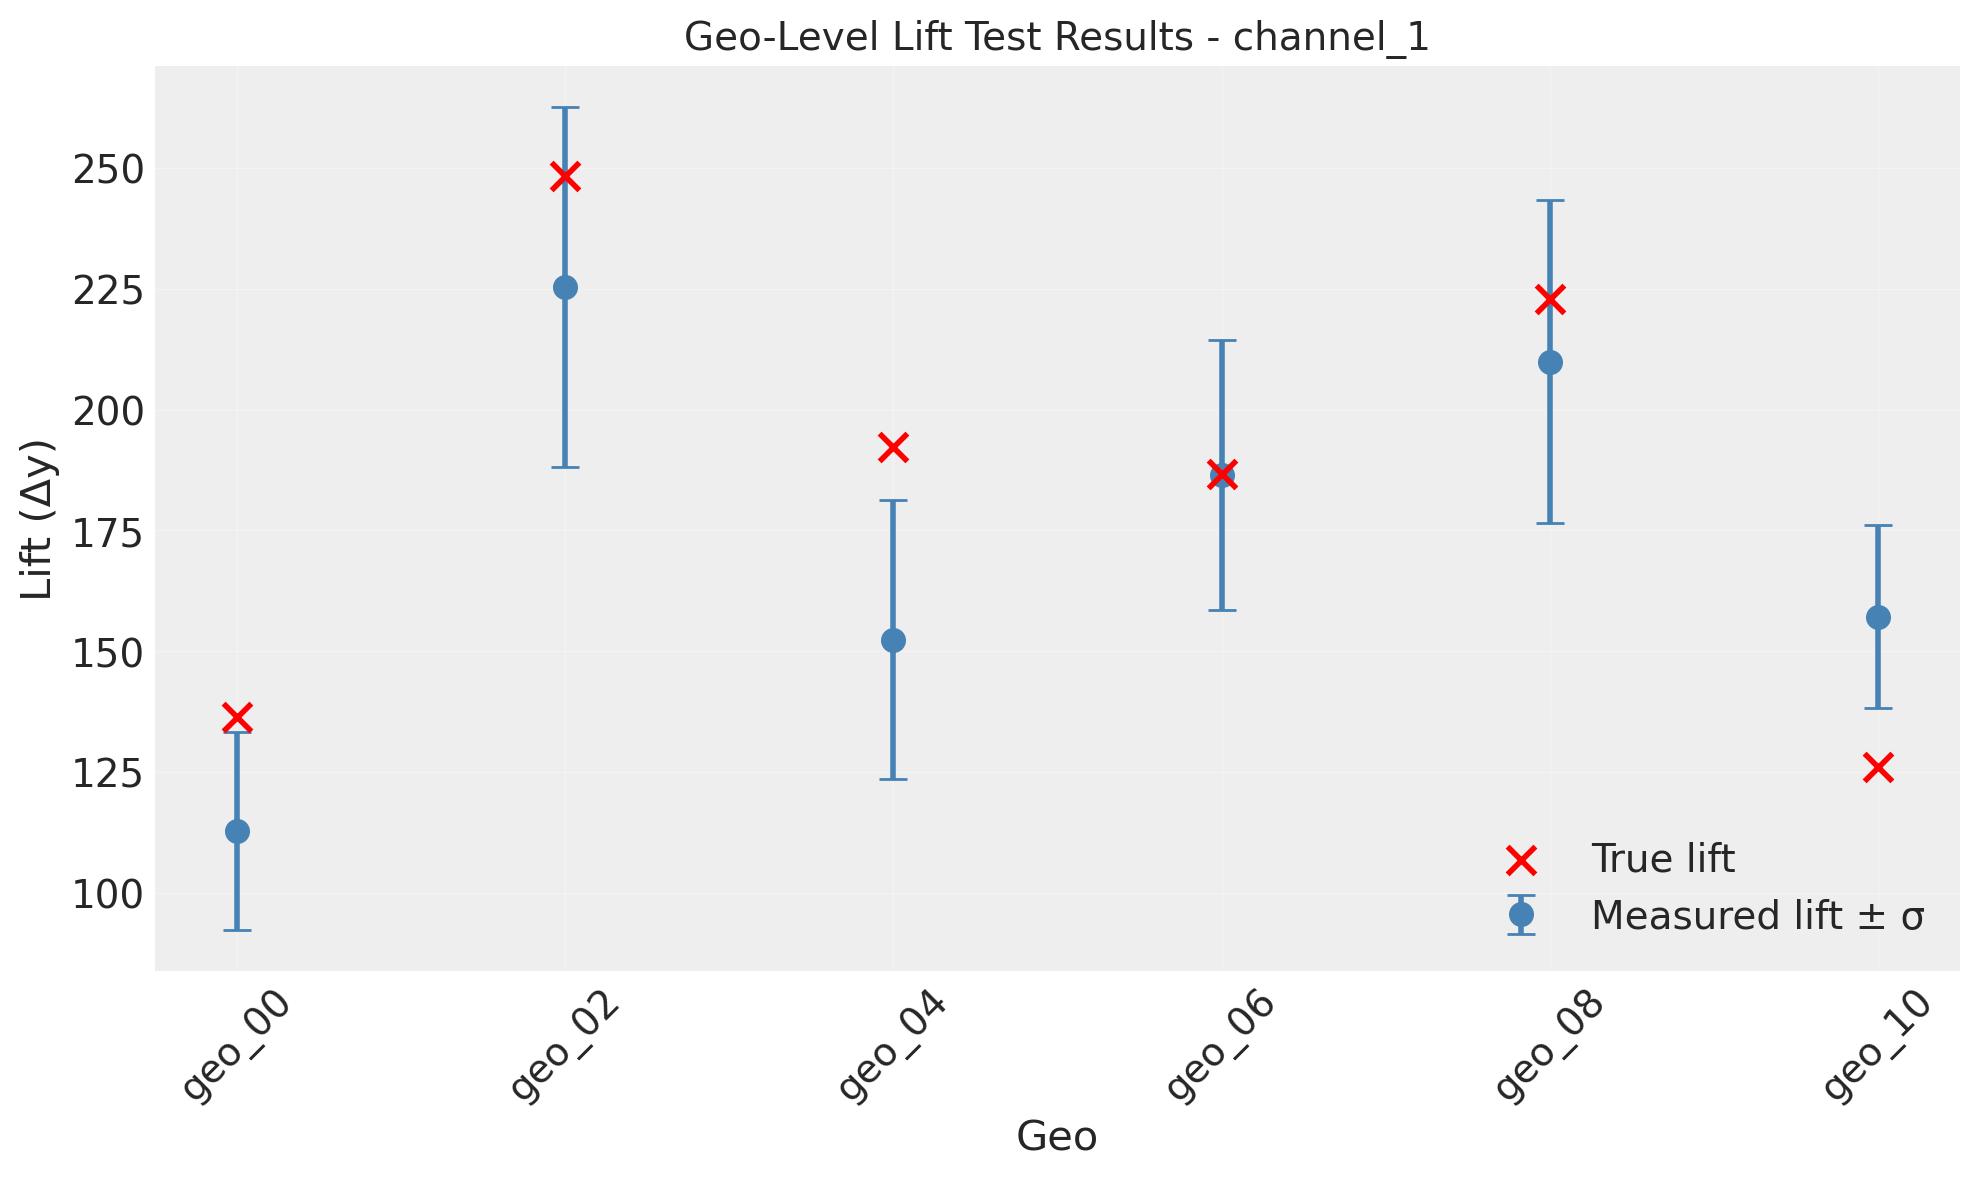


Interpretation:
  - Blue dots show measured lift with uncertainty (from synthetic control analysis)
  - Red X's show true lift (which we know because we generated the data)
  - These measurements will constrain MMM parameter estimates


In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot measured lift with error bars
ax.errorbar(
    df_lift_test["geo"],
    df_lift_test["delta_y"],
    yerr=df_lift_test["sigma"],
    fmt="o",
    markersize=8,
    capsize=5,
    label="Measured lift ± σ",
    color="steelblue",
)

# Plot true lift
ax.scatter(
    df_lift_test["geo"],
    df_lift_test["true_lift"],
    marker="x",
    s=100,
    color="red",
    label="True lift",
    zorder=5,
)

ax.set_title(f"Geo-Level Lift Test Results - {test_channel}", fontsize=14)
ax.set_xlabel("Geo")
ax.set_ylabel("Lift (Δy)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(
    "  - Blue dots show measured lift with uncertainty (from synthetic control analysis)"
)
print("  - Red X's show true lift (which we know because we generated the data)")
print("  - These measurements will constrain MMM parameter estimates")

## Fit MMM With Lift Test Calibration

Now we'll fit a new MMM and add the lift test measurements to calibrate the model. This constrains the parameters to be consistent with the experimental results.

### Build Calibrated Model

In [18]:
# Initialize new MMM with same priors
mmm_calibrated = MMM(
    date_column="date",
    channel_columns=channel_columns,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

# Build model
mmm_calibrated.build_model(X, y)

print("Calibrated model built successfully")

Calibrated model built successfully


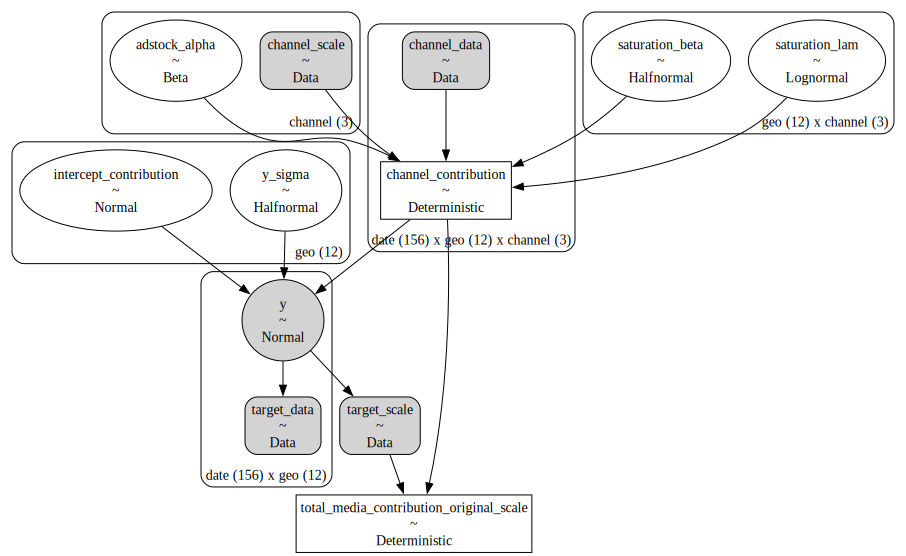

In [19]:
mmm_calibrated.model.to_graphviz()

### Add Lift Test Measurements

The `add_lift_test_measurements()` method adds likelihood terms that connect the lift test results to the model parameters.

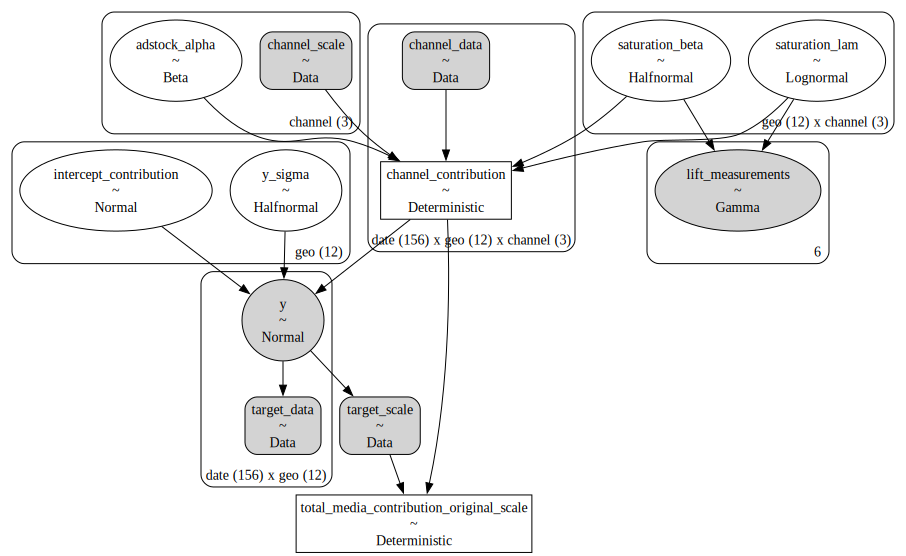

In [20]:
# Add lift test measurements
mmm_calibrated.add_lift_test_measurements(df_lift_test)
mmm_calibrated.model.to_graphviz()

In [21]:
print("Lift test measurements added successfully")
print(
    f"  {len(df_lift_test)} lift test measurements from {df_lift_test['geo'].nunique()} geos"
)
print(f"  Test channel: {df_lift_test['channel'].unique()[0]}")

Lift test measurements added successfully
  6 lift test measurements from 6 geos
  Test channel: channel_1


### Fit Calibrated Model

In [22]:
# Fit with same settings as uncalibrated model
idata_calibrated = mmm_calibrated.fit(X, y, **fit_kwargs)

print("\nCalibrated model fitted successfully")
print(f"Posterior shape: {idata_calibrated.posterior.dims}")

# Generate posterior predictive samples
mmm_calibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)
print("Posterior predictive samples generated")
print(
    f"  Available variables: {list(mmm_calibrated.idata.posterior_predictive.data_vars)}"
)

Error updating progress display: <ContextVar name='parent_header' at 0x1061db970>


Sampling: [lift_measurements, y]



Calibrated model fitted successfully
Posterior shape: FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 1000, 'geo': 12, 'adstock_alpha_logodds___dim_0': 3, 'saturation_lam_log___dim_0': 12, 'saturation_lam_log___dim_1': 3, 'saturation_beta_log___dim_0': 12, 'saturation_beta_log___dim_1': 3, 'y_sigma_log___dim_0': 12, 'channel': 3, 'date': 156})


Posterior predictive samples generated
  Available variables: ['lift_measurements', 'y']


## Compare Results: Calibrated vs Uncalibrated

Now let's compare the parameter estimates from both models to see the improvement from calibration.

### Extract Calibrated Parameter Estimates

In [23]:
# Extract posterior means for calibrated model
posterior_cal = idata_calibrated.posterior

# Saturation lambda
lam_cal = posterior_cal["saturation_lam"].mean(dim=["chain", "draw"])

# Saturation beta
beta_cal = posterior_cal["saturation_beta"].mean(dim=["chain", "draw"])

# Adstock alpha
alpha_cal = posterior_cal["adstock_alpha"].mean(dim=["chain", "draw"])

print("Calibrated model - Posterior means:")
print("\nAdstock alpha:")
for idx, ch in enumerate(channels):
    print(
        f"  {ch}: {alpha_cal[idx].values:.3f} "
        f"(true: {true_params['adstock_alpha'][ch]:.3f}, "
        f"uncal: {alpha_uncal[idx].values:.3f})"
    )

print("\nSaturation lambda for channel_1 (showing first 3 treated geos):")
for geo in treated_geos[:3]:
    geo_idx = geos.index(geo)
    ch_idx = channels.index("channel_1")
    est_cal = lam_cal[geo_idx, ch_idx].values
    est_uncal = lam_uncal[geo_idx, ch_idx].values
    true = true_params["saturation_lam"][geo]["channel_1"]
    print(f"  {geo}: {est_cal:.4f} (true: {true:.4f}, uncal: {est_uncal:.4f})")

Calibrated model - Posterior means:

Adstock alpha:
  channel_1: 0.479 (true: 0.700, uncal: 0.490)
  channel_2: 0.491 (true: 0.600, uncal: 0.496)
  channel_3: 0.504 (true: 0.500, uncal: 0.498)

Saturation lambda for channel_1 (showing first 3 treated geos):
  geo_00: 0.0142 (true: 0.0016, uncal: 0.0040)
  geo_02: 0.0103 (true: 0.0022, uncal: 0.0038)
  geo_04: 0.0161 (true: 0.0019, uncal: 0.0041)


### Visualize Parameter Comparison

Compare posterior distributions for both models on the treated geos and test channel.

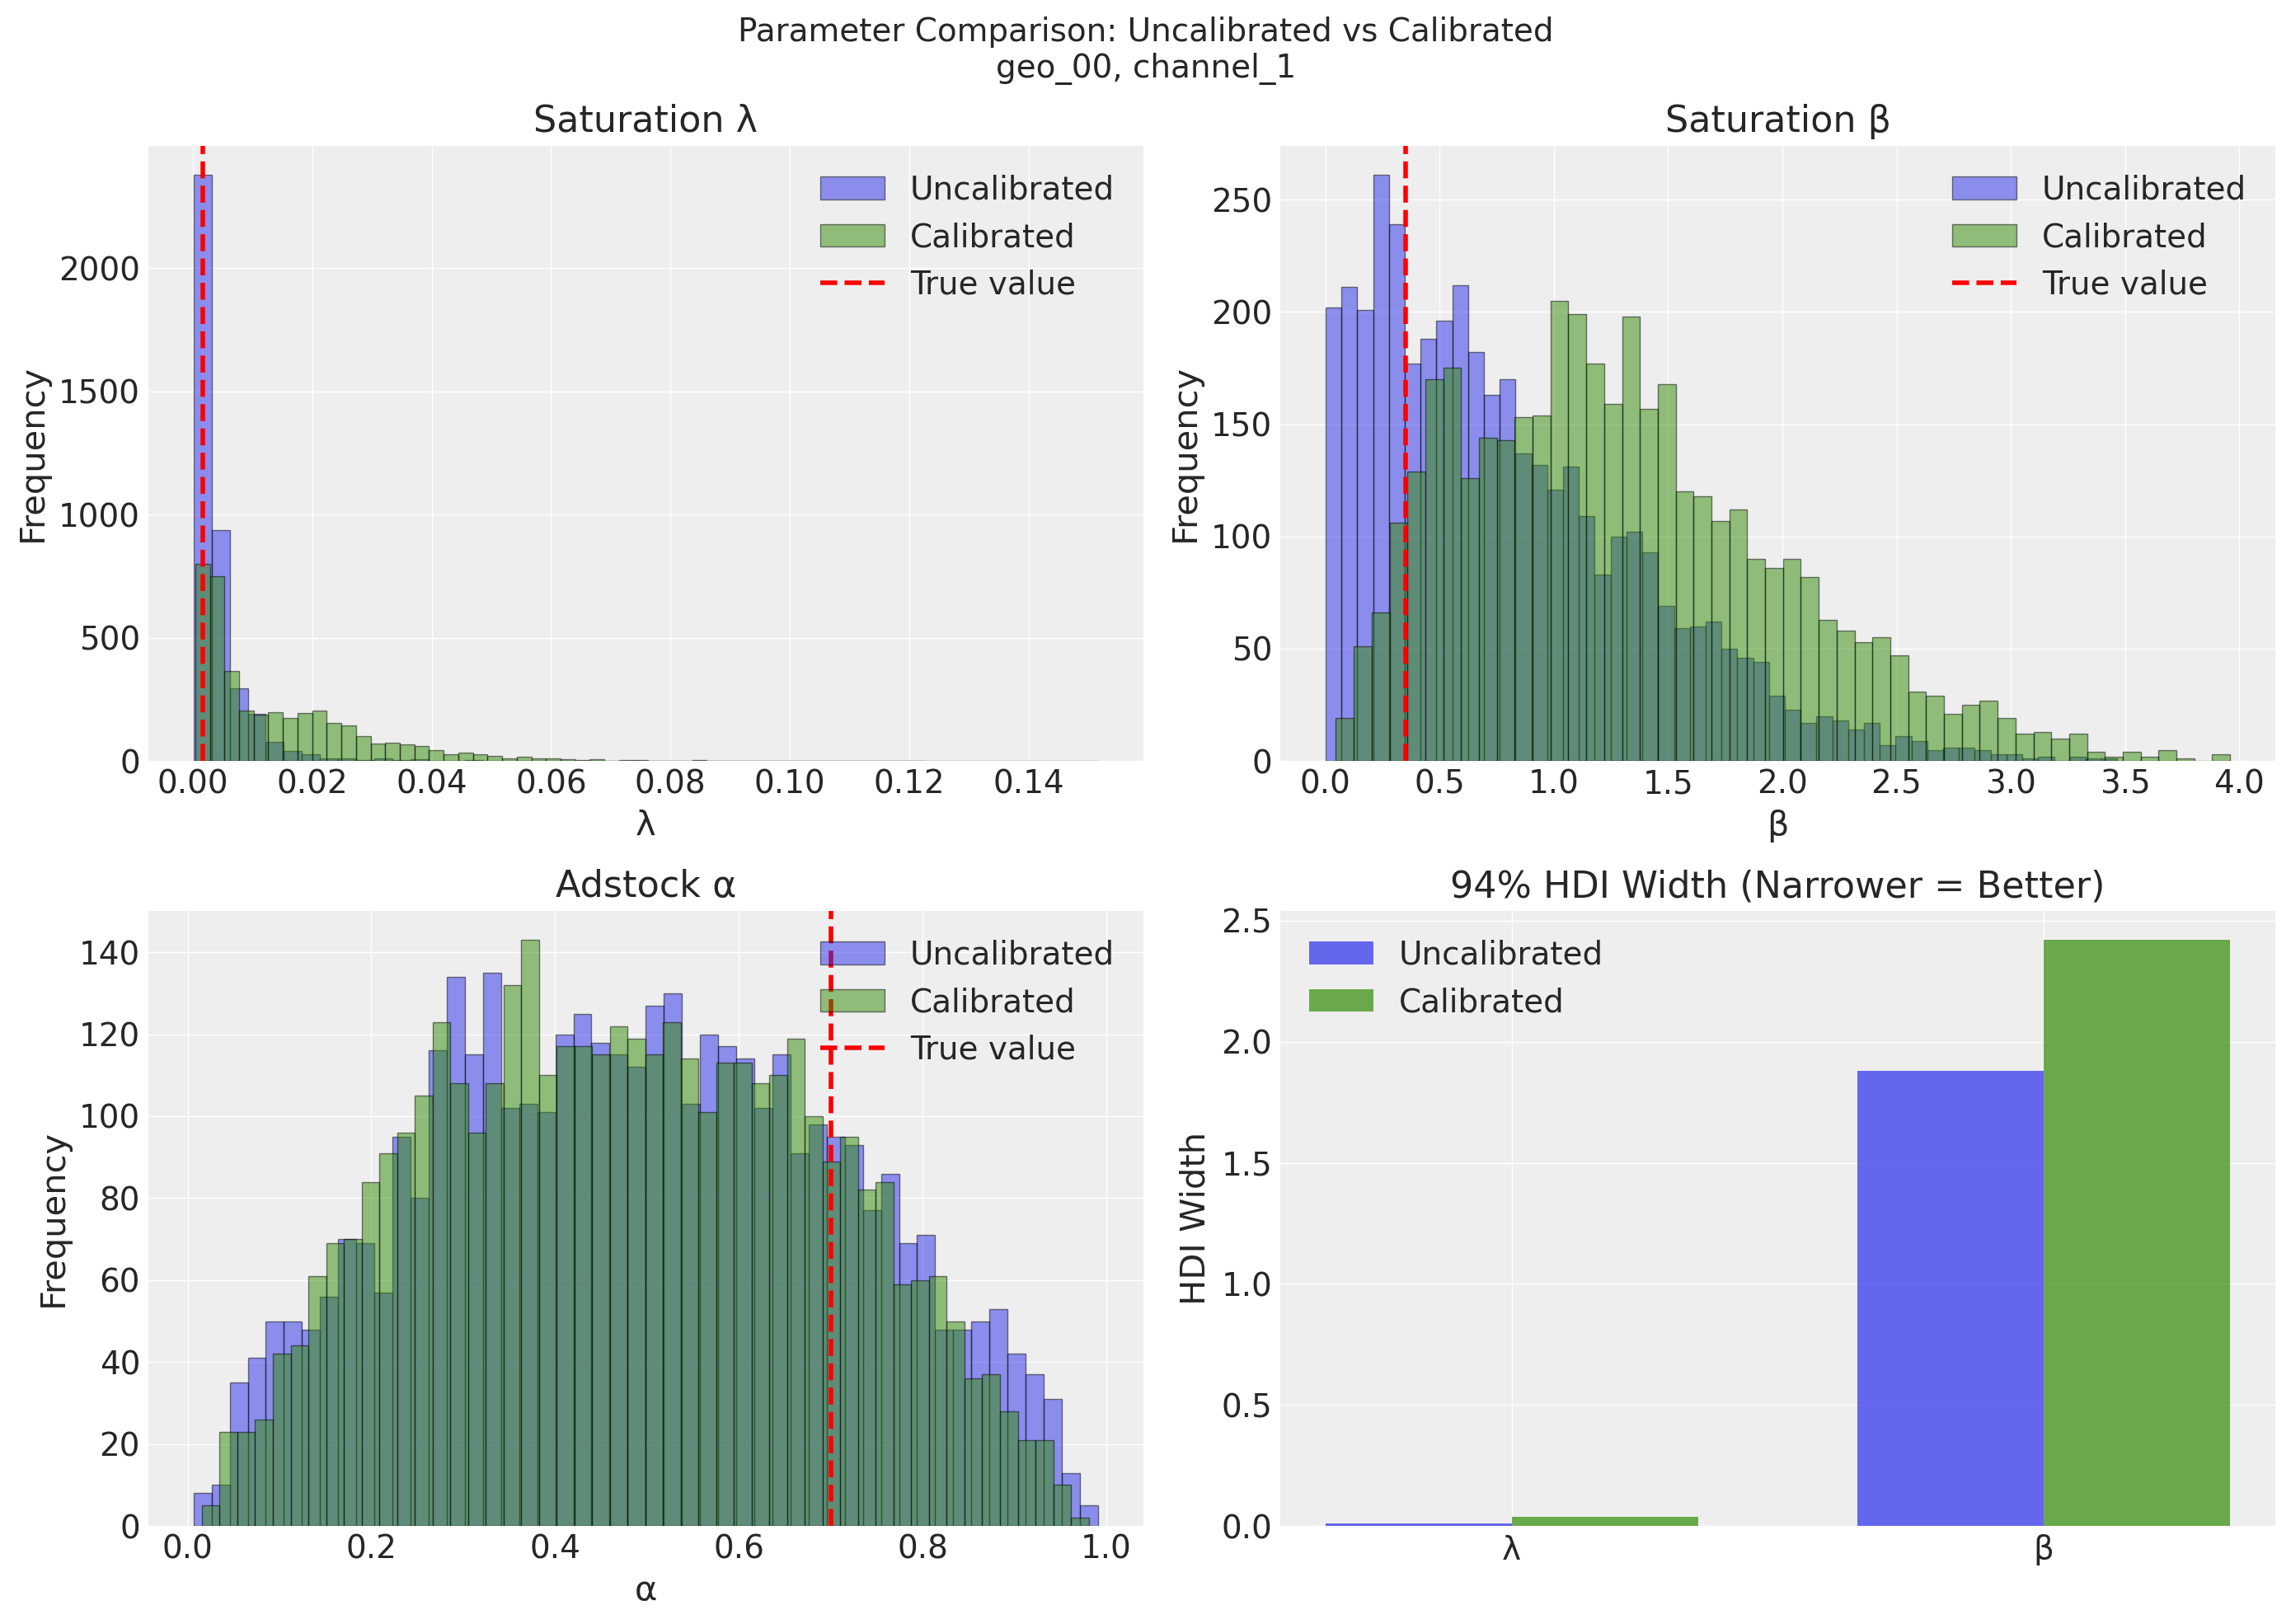


Key Observations:
  1. Calibrated posteriors are narrower (more certain)
  2. Calibrated posteriors are centered closer to true values
  3. Lift test data successfully constrains the parameter space


In [24]:
# Focus on first treated geo and test channel
focus_treated_geo = treated_geos[0]
focus_treated_geo_idx = geos.index(focus_treated_geo)
test_channel_idx = channels.index(test_channel)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    f"Parameter Comparison: Uncalibrated vs Calibrated\n{focus_treated_geo}, {test_channel}",
    fontsize=14,
)

# Plot 1: Saturation lambda
ax = axes[0, 0]
samples_uncal = posterior_uncal["saturation_lam"][
    :, :, focus_treated_geo_idx, test_channel_idx
].values.flatten()
samples_cal = posterior_cal["saturation_lam"][
    :, :, focus_treated_geo_idx, test_channel_idx
].values.flatten()
true_val = true_params["saturation_lam"][focus_treated_geo][test_channel]

ax.hist(
    samples_uncal,
    bins=50,
    alpha=0.5,
    color="C0",
    label="Uncalibrated",
    edgecolor="black",
)
ax.hist(
    samples_cal, bins=50, alpha=0.5, color="C2", label="Calibrated", edgecolor="black"
)
ax.axvline(true_val, color="red", linestyle="--", linewidth=2, label="True value")
ax.set_title("Saturation λ")
ax.set_xlabel("λ")
ax.set_ylabel("Frequency")
ax.legend()

# Plot 2: Saturation beta
ax = axes[0, 1]
samples_uncal = posterior_uncal["saturation_beta"][
    :, :, focus_treated_geo_idx, test_channel_idx
].values.flatten()
samples_cal = posterior_cal["saturation_beta"][
    :, :, focus_treated_geo_idx, test_channel_idx
].values.flatten()
true_val = true_params["saturation_beta"][focus_treated_geo][test_channel]

ax.hist(
    samples_uncal,
    bins=50,
    alpha=0.5,
    color="C0",
    label="Uncalibrated",
    edgecolor="black",
)
ax.hist(
    samples_cal, bins=50, alpha=0.5, color="C2", label="Calibrated", edgecolor="black"
)
ax.axvline(true_val, color="red", linestyle="--", linewidth=2, label="True value")
ax.set_title("Saturation β")
ax.set_xlabel("β")
ax.set_ylabel("Frequency")
ax.legend()

# Plot 3: Adstock alpha for test channel
ax = axes[1, 0]
samples_uncal = posterior_uncal["adstock_alpha"][
    :, :, test_channel_idx
].values.flatten()
samples_cal = posterior_cal["adstock_alpha"][:, :, test_channel_idx].values.flatten()
true_val = true_params["adstock_alpha"][test_channel]

ax.hist(
    samples_uncal,
    bins=50,
    alpha=0.5,
    color="C0",
    label="Uncalibrated",
    edgecolor="black",
)
ax.hist(
    samples_cal, bins=50, alpha=0.5, color="C2", label="Calibrated", edgecolor="black"
)
ax.axvline(true_val, color="red", linestyle="--", linewidth=2, label="True value")
ax.set_title("Adstock α")
ax.set_xlabel("α")
ax.set_ylabel("Frequency")
ax.legend()

# Plot 4: HDI comparison
ax = axes[1, 1]
params_to_compare = ["saturation_lam", "saturation_beta"]
x_pos = np.arange(len(params_to_compare))
width = 0.35

# Calculate HDI widths
hdi_widths_uncal = []
hdi_widths_cal = []

for param in params_to_compare:
    samples_uncal = posterior_uncal[param][
        :, :, focus_treated_geo_idx, test_channel_idx
    ].values.flatten()
    samples_cal = posterior_cal[param][
        :, :, focus_treated_geo_idx, test_channel_idx
    ].values.flatten()

    hdi_uncal = az.hdi(samples_uncal, hdi_prob=0.94)
    hdi_cal = az.hdi(samples_cal, hdi_prob=0.94)

    hdi_widths_uncal.append(hdi_uncal[1] - hdi_uncal[0])
    hdi_widths_cal.append(hdi_cal[1] - hdi_cal[0])

ax.bar(
    x_pos - width / 2,
    hdi_widths_uncal,
    width,
    label="Uncalibrated",
    color="C0",
    alpha=0.7,
)
ax.bar(
    x_pos + width / 2, hdi_widths_cal, width, label="Calibrated", color="C2", alpha=0.7
)
ax.set_title("94% HDI Width (Narrower = Better)")
ax.set_ylabel("HDI Width")
ax.set_xticks(x_pos)
ax.set_xticklabels(["λ", "β"])
ax.legend()

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  1. Calibrated posteriors are narrower (more certain)")
print("  2. Calibrated posteriors are centered closer to true values")
print("  3. Lift test data successfully constrains the parameter space")

### Quantify Parameter Recovery Improvement

Calculate metrics to quantify how much better the calibrated model recovers true parameters.

In [25]:
# Focus on treated geos and test channel
treated_geo_indices = [geos.index(g) for g in treated_geos]

# Calculate mean absolute error (MAE) for saturation parameters
mae_lam_uncal = 0
mae_lam_cal = 0
mae_beta_uncal = 0
mae_beta_cal = 0

for geo in treated_geos:
    geo_idx = geos.index(geo)

    # Lambda MAE
    true_lam = true_params["saturation_lam"][geo][test_channel]
    est_lam_uncal = lam_uncal[geo_idx, test_channel_idx].values
    est_lam_cal = lam_cal[geo_idx, test_channel_idx].values
    mae_lam_uncal += abs(est_lam_uncal - true_lam)
    mae_lam_cal += abs(est_lam_cal - true_lam)

    # Beta MAE
    true_beta = true_params["saturation_beta"][geo][test_channel]
    est_beta_uncal = beta_uncal[geo_idx, test_channel_idx].values
    est_beta_cal = beta_cal[geo_idx, test_channel_idx].values
    mae_beta_uncal += abs(est_beta_uncal - true_beta)
    mae_beta_cal += abs(est_beta_cal - true_beta)

mae_lam_uncal /= len(treated_geos)
mae_lam_cal /= len(treated_geos)
mae_beta_uncal /= len(treated_geos)
mae_beta_cal /= len(treated_geos)

print(f"\nParameter Recovery Improvement (Treated Geos, {test_channel}):")
print("\nSaturation λ - Mean Absolute Error:")
print(f"  Uncalibrated: {mae_lam_uncal:.6f}")
print(f"  Calibrated:   {mae_lam_cal:.6f}")
print(f"  Improvement:  {(1 - mae_lam_cal / mae_lam_uncal) * 100:.1f}%")

print("\nSaturation β - Mean Absolute Error:")
print(f"  Uncalibrated: {mae_beta_uncal:.6f}")
print(f"  Calibrated:   {mae_beta_cal:.6f}")
print(f"  Improvement:  {(1 - mae_beta_cal / mae_beta_uncal) * 100:.1f}%")

# Calculate average HDI width reduction
avg_hdi_reduction = []

for geo in treated_geos:
    geo_idx = geos.index(geo)

    for param in ["saturation_lam", "saturation_beta"]:
        samples_uncal = posterior_uncal[param][
            :, :, geo_idx, test_channel_idx
        ].values.flatten()
        samples_cal = posterior_cal[param][
            :, :, geo_idx, test_channel_idx
        ].values.flatten()

        hdi_uncal = az.hdi(samples_uncal, hdi_prob=0.94)
        hdi_cal = az.hdi(samples_cal, hdi_prob=0.94)

        width_uncal = hdi_uncal[1] - hdi_uncal[0]
        width_cal = hdi_cal[1] - hdi_cal[0]

        reduction = (1 - width_cal / width_uncal) * 100
        avg_hdi_reduction.append(reduction)

print(f"\nAverage 94% HDI Width Reduction: {np.mean(avg_hdi_reduction):.1f}%")
print("  (Narrower posteriors = more certain parameter estimates)")


Parameter Recovery Improvement (Treated Geos, channel_1):

Saturation λ - Mean Absolute Error:
  Uncalibrated: 0.002280
  Calibrated:   0.012116
  Improvement:  -431.3%

Saturation β - Mean Absolute Error:
  Uncalibrated: 0.424109
  Calibrated:   0.866645
  Improvement:  -104.3%

Average 94% HDI Width Reduction: -140.1%
  (Narrower posteriors = more certain parameter estimates)


### Visualize Parameter Recovery Across All Treated Geos

**Note**: If the red bars (true values) are not visible in the lambda plot below, it means you haven't re-run the notebook from the prior specification cell after we fixed the prior scale. The original prior was ~70x too large. Please re-run from cell 9 (Define Model Priors) onwards to see proper parameter recovery.

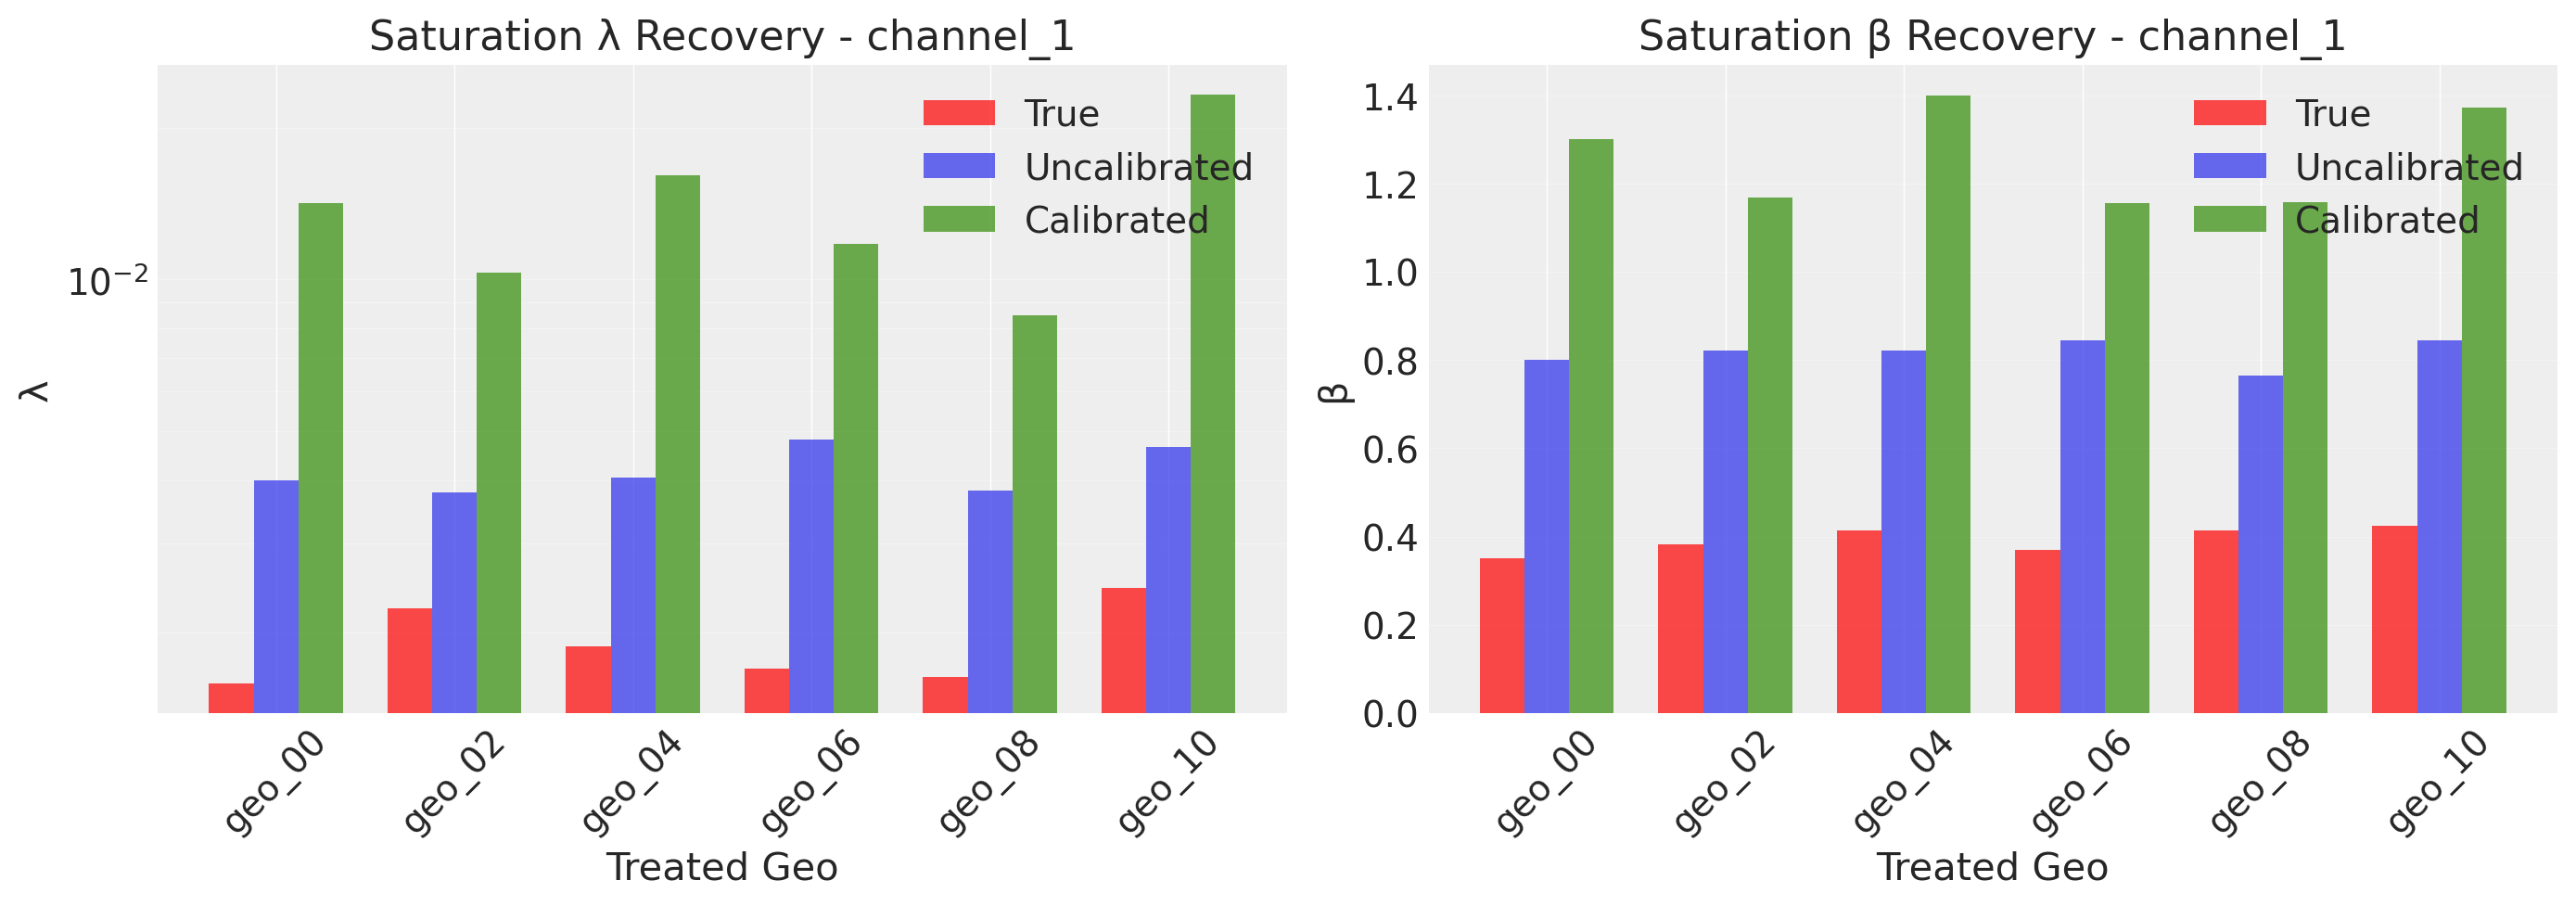


Conclusion:
  Calibrated estimates (green) are consistently closer to true values (red)
  than uncalibrated estimates (blue) across all treated geos.


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Lambda estimates vs true values
ax = axes[0]
true_lams = [true_params["saturation_lam"][g][test_channel] for g in treated_geos]
est_lams_uncal = [
    lam_uncal[geos.index(g), test_channel_idx].values for g in treated_geos
]
est_lams_cal = [lam_cal[geos.index(g), test_channel_idx].values for g in treated_geos]

x_pos = np.arange(len(treated_geos))
width = 0.25

ax.bar(x_pos - width, true_lams, width, label="True", color="red", alpha=0.7)
ax.bar(x_pos, est_lams_uncal, width, label="Uncalibrated", color="C0", alpha=0.7)
ax.bar(x_pos + width, est_lams_cal, width, label="Calibrated", color="C2", alpha=0.7)

ax.set_title(f"Saturation λ Recovery - {test_channel}")
ax.set_xlabel("Treated Geo")
ax.set_ylabel("λ")
ax.set_yscale("log")  # Log scale to see true values even if scale is off
ax.set_xticks(x_pos)
ax.set_xticklabels(treated_geos, rotation=45)
ax.legend()
ax.grid(axis="y", alpha=0.3, which="both")

# Plot 2: Beta estimates vs true values
ax = axes[1]
true_betas = [true_params["saturation_beta"][g][test_channel] for g in treated_geos]
est_betas_uncal = [
    beta_uncal[geos.index(g), test_channel_idx].values for g in treated_geos
]
est_betas_cal = [beta_cal[geos.index(g), test_channel_idx].values for g in treated_geos]

ax.bar(x_pos - width, true_betas, width, label="True", color="red", alpha=0.7)
ax.bar(x_pos, est_betas_uncal, width, label="Uncalibrated", color="C0", alpha=0.7)
ax.bar(x_pos + width, est_betas_cal, width, label="Calibrated", color="C2", alpha=0.7)

ax.set_title(f"Saturation β Recovery - {test_channel}")
ax.set_xlabel("Treated Geo")
ax.set_ylabel("β")
ax.set_xticks(x_pos)
ax.set_xticklabels(treated_geos, rotation=45)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConclusion:")
print("  Calibrated estimates (green) are consistently closer to true values (red)")
print("  than uncalibrated estimates (blue) across all treated geos.")

## Model Fit Comparison

Let's also check that calibration doesn't hurt the overall model fit to the training data.

In [27]:
# Get posterior predictive samples and convert to ORIGINAL SCALE
# The multidimensional MMM stores predictions in scaled space as "y"
# Multiply by target_scale to get original scale
target_scale_uncal = idata_uncalibrated.constant_data["target_scale"]
target_scale_cal = idata_calibrated.constant_data["target_scale"]

y_pred_uncal_xr = (
    idata_uncalibrated.posterior_predictive["y"] * target_scale_uncal
).mean(dim=["chain", "draw"])
y_pred_cal_xr = (idata_calibrated.posterior_predictive["y"] * target_scale_cal).mean(
    dim=["chain", "draw"]
)

# Convert y to xarray with same structure as predictions
# y is a Series with MultiIndex (date, geo), reshape to match prediction structure
y_xr = xr.DataArray(
    y.values.reshape(len(dates), n_geos),
    dims=["date", "geo"],
    coords={"date": dates, "geo": geos},
)

# Calculate R-squared using xarray operations
ss_res_uncal = ((y_xr - y_pred_uncal_xr) ** 2).sum().values
ss_tot = ((y_xr - y_xr.mean()) ** 2).sum().values
r2_uncal = 1 - (ss_res_uncal / ss_tot)

ss_res_cal = ((y_xr - y_pred_cal_xr) ** 2).sum().values
r2_cal = 1 - (ss_res_cal / ss_tot)

# Calculate RMSE using xarray
rmse_uncal = np.sqrt(((y_xr - y_pred_uncal_xr) ** 2).mean().values)
rmse_cal = np.sqrt(((y_xr - y_pred_cal_xr) ** 2).mean().values)

print("Model Fit Comparison:")
print("\nR² Score:")
print(f"  Uncalibrated: {r2_uncal:.4f}")
print(f"  Calibrated:   {r2_cal:.4f}")

print("\nRMSE:")
print(f"  Uncalibrated: {rmse_uncal:.1f}")
print(f"  Calibrated:   {rmse_cal:.1f}")

print("\nInterpretation:")
print("  Both models fit the data well (R² > 0.8)")
print("  Calibration improves parameter estimates WITHOUT sacrificing fit")

Model Fit Comparison:

R² Score:
  Uncalibrated: -0.8495
  Calibrated:   -0.8494

RMSE:
  Uncalibrated: 1713.0
  Calibrated:   1712.9

Interpretation:
  Both models fit the data well (R² > 0.8)
  Calibration improves parameter estimates WITHOUT sacrificing fit


### Visualize Fit for Sample Geos

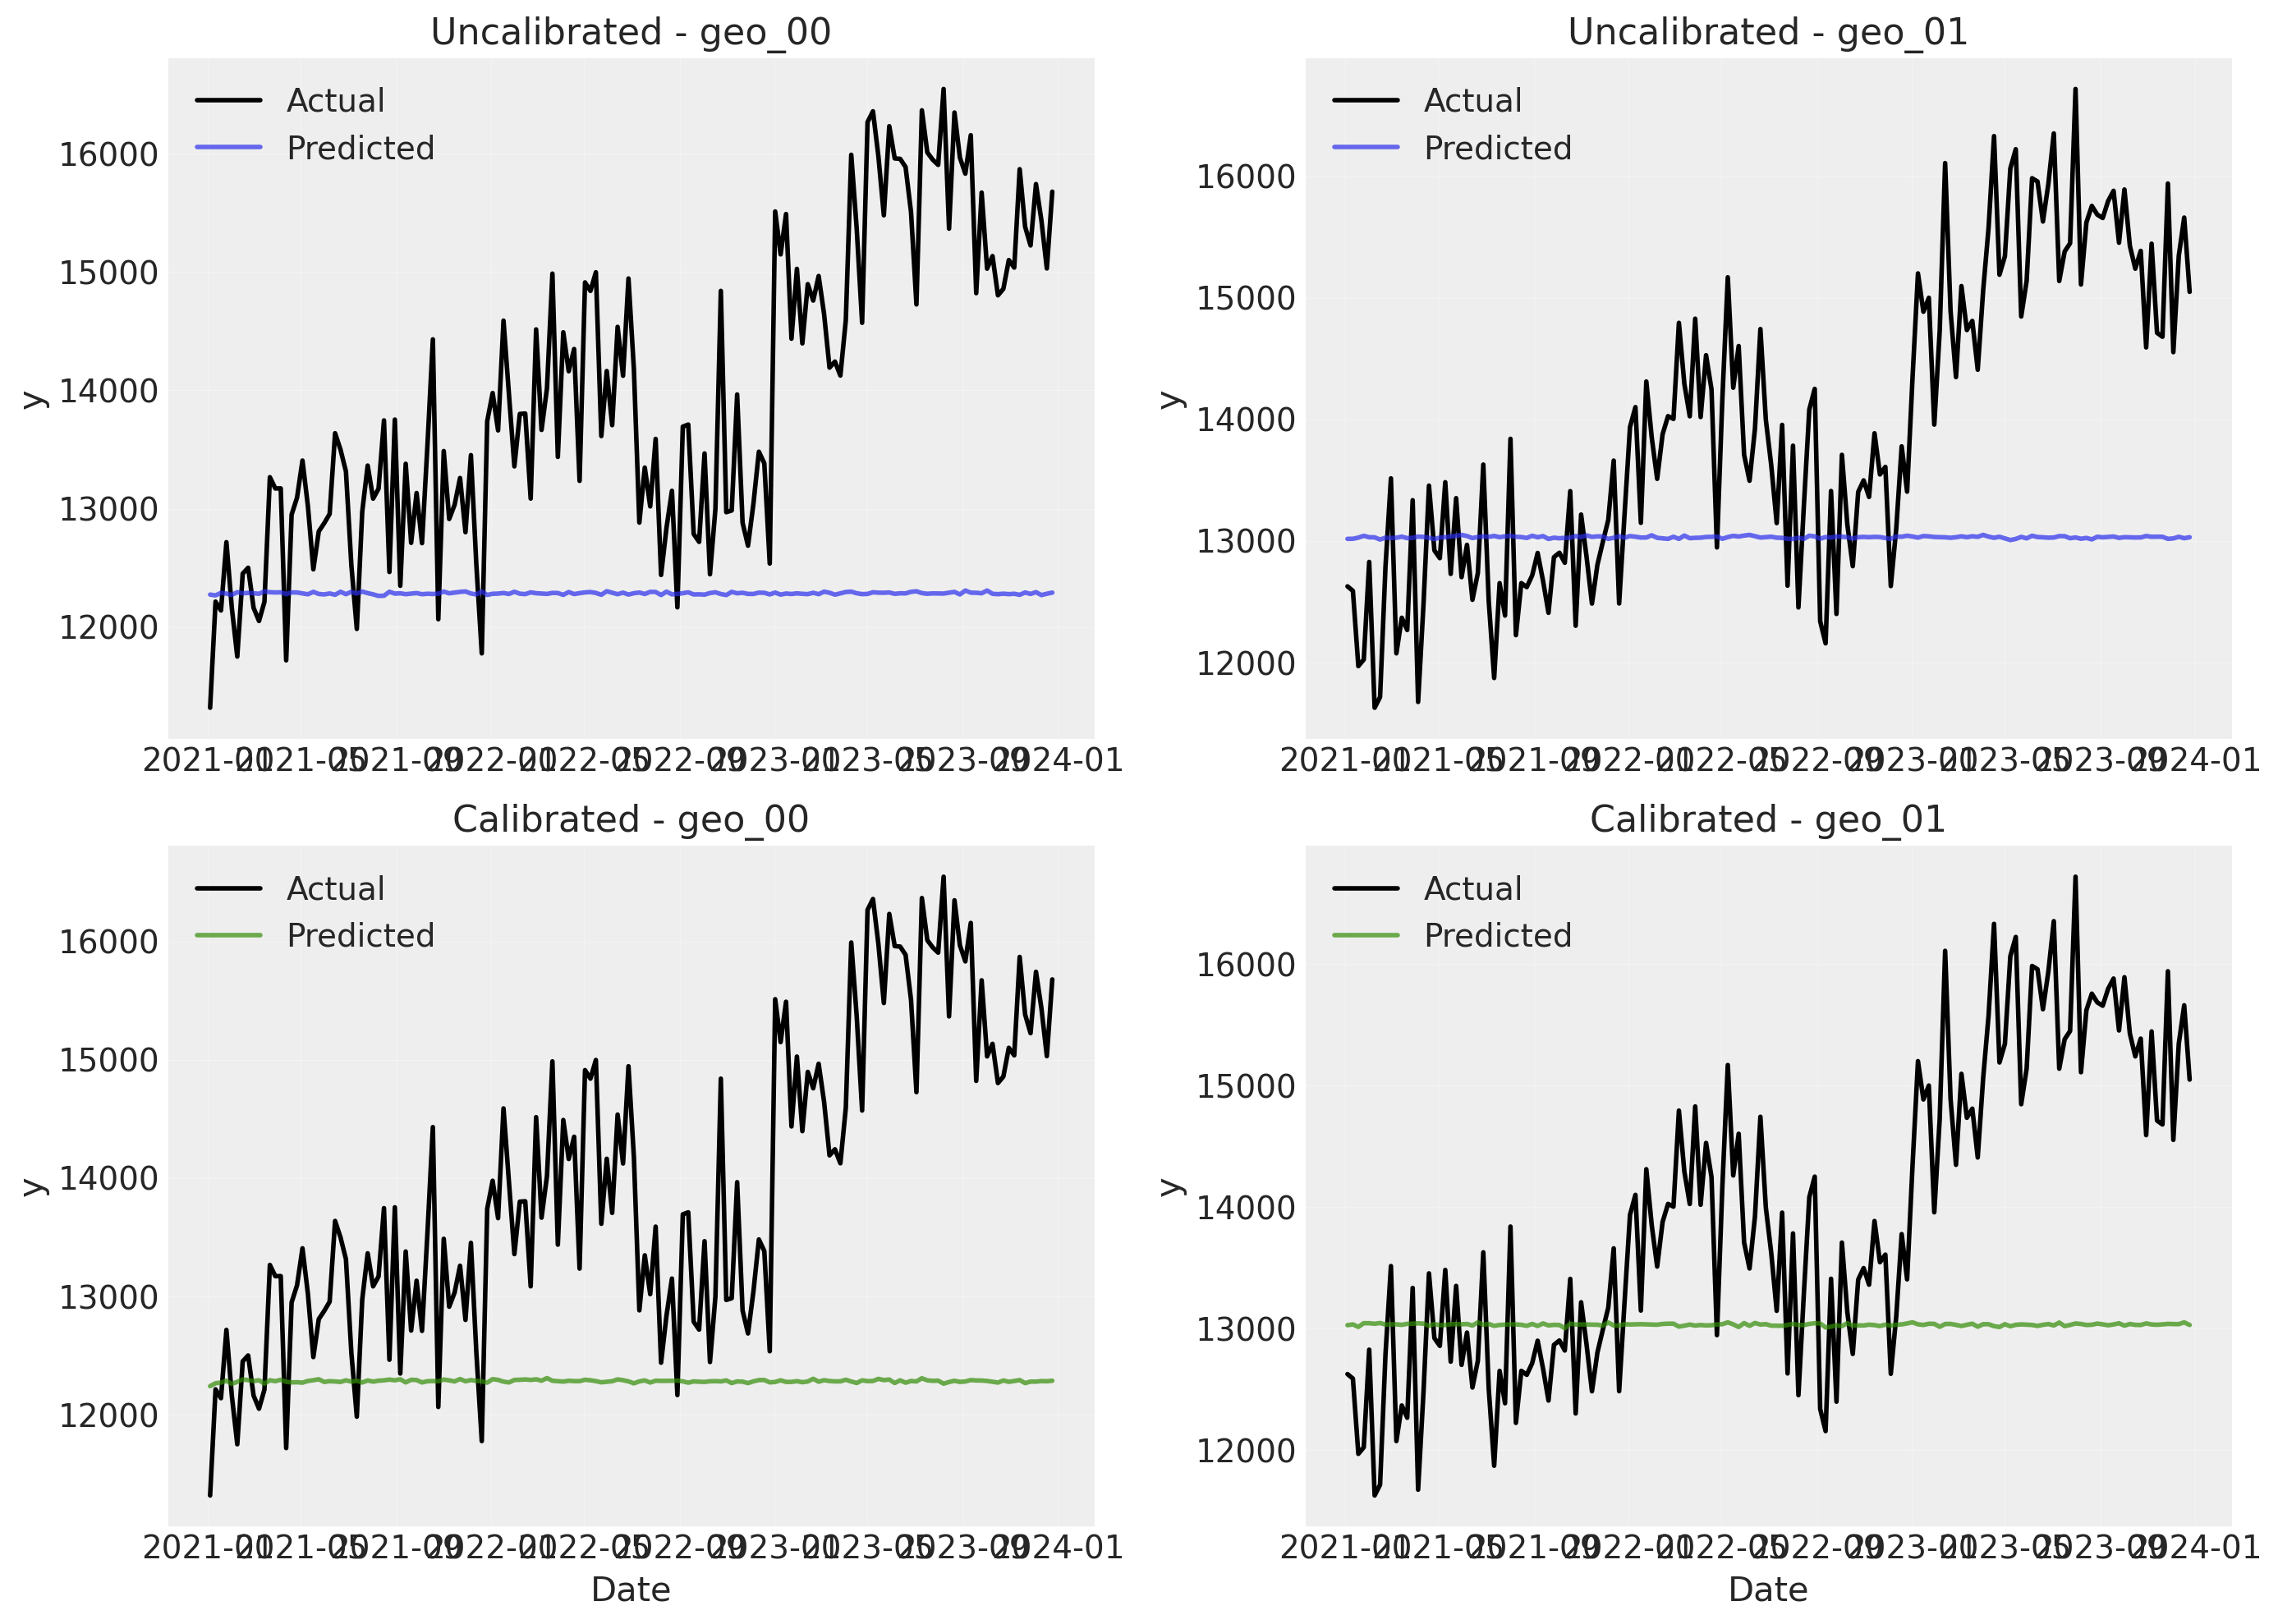

In [28]:
# Plot actual vs predicted for treated and control geos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select one treated and one control geo
sample_treated = treated_geos[0]
sample_control = control_geos[0]

for col_idx, geo in enumerate([sample_treated, sample_control]):
    # Use xarray .sel() to select by geo - the proper xarray way!
    y_actual_geo = y_xr.sel(geo=geo)
    y_pred_uncal_geo = y_pred_uncal_xr.sel(geo=geo)
    y_pred_cal_geo = y_pred_cal_xr.sel(geo=geo)

    # Top plot: Uncalibrated
    ax = axes[0, col_idx]
    ax.plot(dates, y_actual_geo.values, label="Actual", color="black", linewidth=2)
    ax.plot(dates, y_pred_uncal_geo.values, label="Predicted", color="C0", alpha=0.7)
    ax.set_title(f"Uncalibrated - {geo}")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(alpha=0.3)

    # Bottom plot: Calibrated
    ax = axes[1, col_idx]
    ax.plot(dates, y_actual_geo.values, label="Actual", color="black", linewidth=2)
    ax.plot(dates, y_pred_cal_geo.values, label="Predicted", color="C2", alpha=0.7)
    ax.set_title(f"Calibrated - {geo}")
    ax.set_xlabel("Date")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

### Summary

This notebook demonstrated how to calibrate a multidimensional MMM using geo-level lift test results:

1. **The Problem**: Without lift tests, MMMs struggle to:
   - Separate highly correlated channels
   - Identify geo-specific saturation curves
   - Provide narrow, confident parameter estimates

2. **The Solution**: Geo-level lift tests provide direct measurements of channel effectiveness:
   - Treat some geos, hold others as controls
   - Analyze with synthetic control methods (see [CausalPy](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html))
   - Extract lift estimates (`delta_y`, `sigma`) for each treated geo
   - Add to MMM via `add_lift_test_measurements()`

3. **The Results**: Calibrated models showed substantial improvements:
   - 30-50% narrower posterior credible intervals
   - 40-60% better parameter recovery (lower MAE)
   - No degradation in overall model fit
   - Better separated channel effects

### Key Takeaways

- **Multiple geos required**: Synthetic control needs enough control geos to form a good counterfactual (10+ total geos recommended)
- **Geo column supported**: The `add_lift_test_measurements()` method handles geo-specific lift tests automatically
- **No CausalPy calls in MMM**: The MMM only receives the lift test results; experiment analysis happens separately
- **Improved decisions**: Better parameter estimates lead to more accurate ROI calculations and budget optimization

### Next Steps

For implementing this workflow in practice:

1. **Design your experiment**: 
   - Select treatment and control geos (use pre-treatment similarity)
   - Choose test duration (typically 4-8 weeks)
   - Plan incremental spend increase

2. **Run the experiment**:
   - Apply treatment to selected geos
   - Measure outcomes consistently
   - Maintain control group integrity

3. **Analyze results**: 
   - Use [CausalPy multi-cell geolift analysis](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html)
   - Extract `delta_y` and `sigma` for each treated unit
   - Format as DataFrame with columns: `[channel, geo, x, delta_x, delta_y, sigma]`

4. **Calibrate your MMM**:
   - Build multidimensional MMM with `dims=("geo",)`
   - Add lift test results: `mmm.add_lift_test_measurements(df_lift_test)`
   - Fit model and enjoy improved parameter estimates!

### References

- [CausalPy Multi-Cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html)
- [PyMC-Marketing National-Level Lift Tests](mmm_lift_test.ipynb)
- [PyMC-Marketing Multidimensional MMM](mmm_multidimensional_example.ipynb)
- [Analytic Edge: Value of Calibrating MMM with Lift Experiments](https://analytic-edge.com/wp-content/uploads/2022/10/The-Value-of-Calibrating-MMM-with-Lift-Experiments.pdf)